# interpret static embedding

In [18]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
from ruamel.yaml import YAML
mpl.rcParams['figure.dpi'] = 150

In [19]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from collections import defaultdict

import sys
sys.path.append("../..")

# Code

In [21]:
print([d.name for d in (data_dir / "runs/").iterdir()])
print([d.name for d in (data_dir / "runs/ealstm_less_vars_2004_1607_1334").glob("*")])

(data_dir / "runs/ealstm_less_vars_2004_1607_1334")
(data_dir / "runs/lstm_less_vars_2004_1507_1028")

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p']
['config.yml', 'events.out.tfevents.1594906656.GPU_MachineLearning.22441.0', 'model_epoch001.pt', 'model_epoch002.pt', 'model_epoch003.pt', 'model_epoch004.pt', 'model_epoch005.pt', 'model_epoch006.pt', 'model_epoch007.pt', 'model_epoch008.pt', 'model_epoch009.pt', 'model_epoch010.pt', 'model_epoch011.pt', 'valid_ds.nc', 'results_ealstm_less_vars_2004_1607_1334_E002.csv', 'results_ealstm_less_vars_2004_1607_1334_E006.csv', 'model_epoch012.pt', 'results_ealstm_less_vars_2004_1607_1334_E007.csv', 'results_ealstm_less_vars_2004_1607_1334_E001.csv', 'results_ealstm_less_vars_2004_1607_1334_E008.csv', 'results_ealstm_less_vars_2004_1607_1334_E009.csv', 'results_ealstm_less_vars_2004_1607_1334_E010.csv', 'model_epoch013.pt', 'results_ealstm_less_vars_2004_1607_1334_E005.csv', 'results_ealstm_less_vars_2004_1607_1334_E004.c

PosixPath('/cats/datastore/data/runs/lstm_less_vars_2004_1507_1028')

In [22]:
import sys
sys.path.insert(1, '/home/tommy/tommy_multiple_forcing')

from codebase.modelzoo.ealstm import EALSTM
from codebase.modelzoo.cudalstm import CudaLSTM
from codebase.data.camelstxt import CamelsGBCSV
from codebase.data import get_h5_dataset
from codebase.data.utils import load_basin_file
from codebase.data.camelsh5 import CamelsGBH5
from codebase.data.hdf5utils import create_h5_file
from codebase.config import parse_config
from codebase.errors import NoTrainDataError
from codebase.training.regressiontrainer import RegressionTrainer

## Load in config file

In [23]:
# Config file
config_path = (data_dir / "runs/ealstm_less_vars_2004_1607_1334/config.yml") 
yaml = YAML(typ="safe")      
cfg = yaml.load(config_path)
cfg = parse_config(cfg)

In [24]:
assert (data_dir / "CAMELS_GB_DATASET").exists()
# assert (data_dir / "runs/lstm_less_vars_2004_1507_1028/train_data/train_data_scaler.p").exists()
# assert (data_dir / "runs/lstm_less_vars_2004_1507_1028/train_data/train_data.h5").exists()
assert (data_dir / "runs/train_data_scaler.p").exists()
assert (data_dir / "runs/train_data.h5").exists()
assert Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt').exists()

cfg["data_dir"] = data_dir / "CAMELS_GB_DATASET"
cfg["scaler_file"] = data_dir / "runs/train_data_scaler.p"
cfg["h5_file"] = data_dir / "runs/train_data.h5"
cfg["train_basin_file"] = Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt')
cfg["validation_basin_file"] = Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt')
cfg["test_basin_file"] = Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt')

# run directory
run_dir = data_dir / "runs/ealstm_less_vars_2004_1607_1334"

## Extra Processes

In [25]:
# Create new .h5 dataset and new .p scaler object
if False:
    fname = cfg["scaler_file"].name
    parents = cfg["scaler_file"].parents[2]
    new_scaler_file = parents / fname

    fname = cfg["h5_file"].name
    parents = cfg["h5_file"].parents[2]
    new_h5_file = parents / fname

    create_h5_file(
        basins=basins,
        cfg=cfg,
        h5_file=new_h5_file,
        scaler_file=new_scaler_file,
    )

In [26]:
# trainer = RegressionTrainer(cfg)
# trainer
if False:
    ds = get_h5_dataset(cfg)

In [27]:
if False:
    if not "attributes" in [k for k in globals().keys()]:
        # load in the attributes (static data)
        h5 = CamelsGBH5(cfg)
        attributes = h5._load_attributes()
        # means = attributes.mean()
        # stds = attributes.std()
    else:
        pass
    attributes.head()

In [28]:
# Get the list of basins that we actually got results for
lstm_results = pd.read_csv(data_dir / "runs/lstm_less_vars_2004_1507_1028/results_lstm_less_vars_2004_1507_1028_E015.csv")
VALID_BASINS = (lstm_results["station_id"].unique())

In [29]:
## load in DATA
# read in the training data
ds = xr.open_dataset(data_dir / f'RUNOFF/features/one_timestep_forecast/data.nc')

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static[cfg["camels_attributes"]].to_dataframe()
static = static[np.isin(static.index, VALID_BASINS)]

ds['station_id'] = ds['station_id'].astype(int)

# Create Model Embeddings

In [30]:
# Initialize model
model = EALSTM(cfg)
model_path = run_dir / "model_epoch011.pt"
model.load_state_dict(torch.load(model_path, map_location="cpu"))

# # extract weight and bias of input gate
# weight = model.lstm.weight_sh
# bias = model.lstm.bias_s

# # model information
# input_size_dyn = len(cfg["dynamic_inputs"])
# input_size_stat = len(cfg["static_inputs"] + cfg["camels_attributes"])

<All keys matched successfully>

In [31]:
basins = load_basin_file(Path(cfg["train_basin_file"]))
# mode = train validation test
mode = "test"
# scaler 
with open(cfg["scaler_file"], "rb") as fp:
    scaler = pickle.load(fp)
scaler["camels_attr_mean"]

EMBEDDING_FILE = config_path.parents[0] / "EMBEDDINGS.pkl"
if not (EMBEDDING_FILE).exists():
    # CALCULATE EMBEDDINGS
    ignore_basins = []
    all_embeddings = []
    for basin in tqdm(basins):
        try: 
            ds_test = CamelsGBCSV(
                    basin=basin,
                    cfg=cfg,
                    mode=mode,
                    scaler=scaler,
            )

            # get static weights/biases
            static_weights, static_bias = [p for p in model.input_net.parameters()]

            # CALCULATE the input gate embeddings
            # input_gate = torch.sigmoid(torch.addmm(static_bias, ds_test.attributes, static_weights))
            input_gate = torch.sigmoid(model.input_net(ds_test.attributes))
            embedding = input_gate.detach().numpy()
            all_embeddings.append(embedding)

        except NoTrainDataError:
            print(f"{basin} has no training data")
            ignore_basins.append(basin)

    all_embeddings = np.array(all_embeddings)
    embed_dict = {"embeddings": all_embeddings, "missing_basins": ignore_basins, "all_basins": basins}
    with EMBEDDING_FILE.open("wb") as fp:
        pickle.dump(embed_dict, fp)
    
else:
    # LOAD EMBEDDINGS
    with EMBEDDING_FILE.open("rb") as fp:
        embed_dict = pickle.load(fp)
        
        
all_embeddings = embed_dict["embeddings"]
ignore_basins = embed_dict["missing_basins"]
all_basins = embed_dict["all_basins"]
ORDER = [basin_id for basin_id in all_basins if basin_id not in ignore_basins]

Each column corresponds to one basin and the rows denote the input gate value of the **`n hidden`** LSTM cells. The basins are ordered by ascending CAMELS GB gauge id.

Text(0, 0.5, 'Activation')

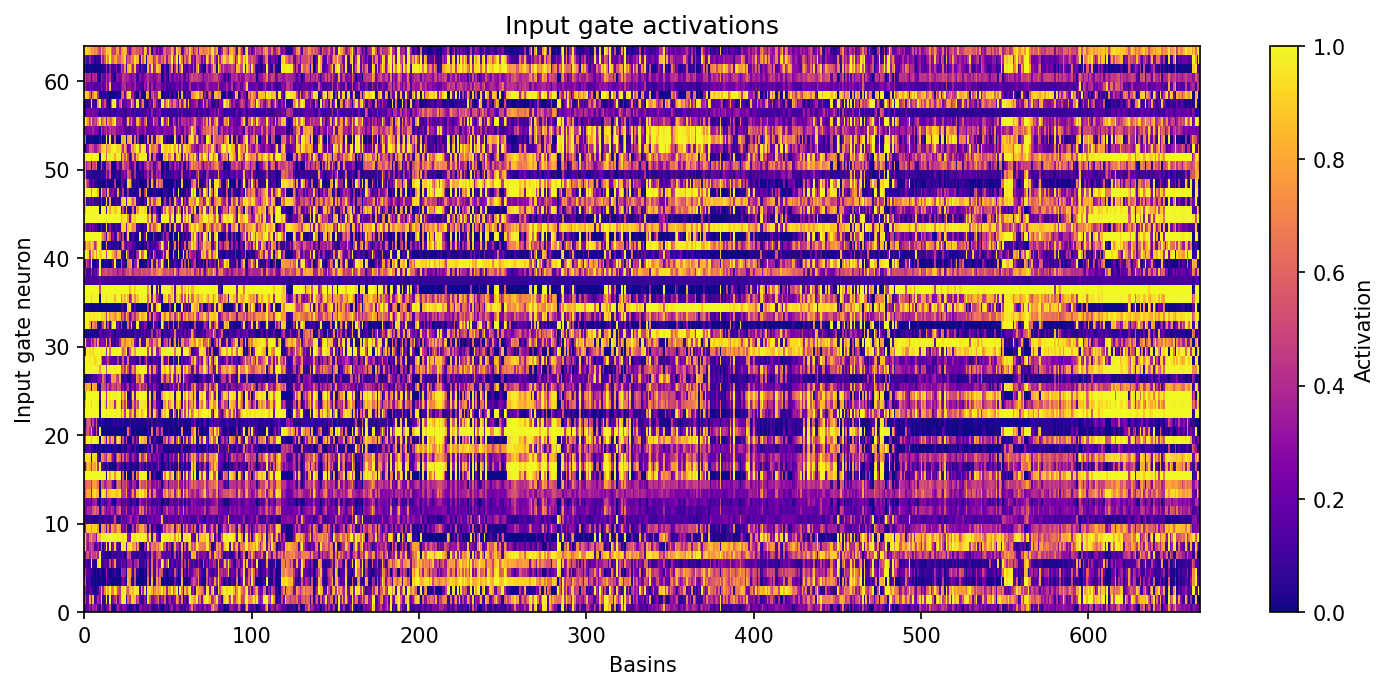

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(all_embeddings.T, cmap='plasma')
ax.set_xlabel("Basins")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

In [148]:
def order_by_static_feature(static_feature: str) -> np.ndarray:
    feature_order = all_static.sel(station_id=[int(s) for s in ORDER])[["gauge_name", static_feature]].sortby(static_feature).station_id.values
    # create df of reordered index
    d = pd.DataFrame({"station_id": ORDER})
    d = d.reset_index().rename({"index": "idx"}, axis=1).set_index("station_id")
    reorder = d.loc[[str(si) for si in feature_order]].reset_index().idx.values
    
    return reorder

reorder = order_by_static_feature("aridity")

Text(0, 0.5, 'Activation')

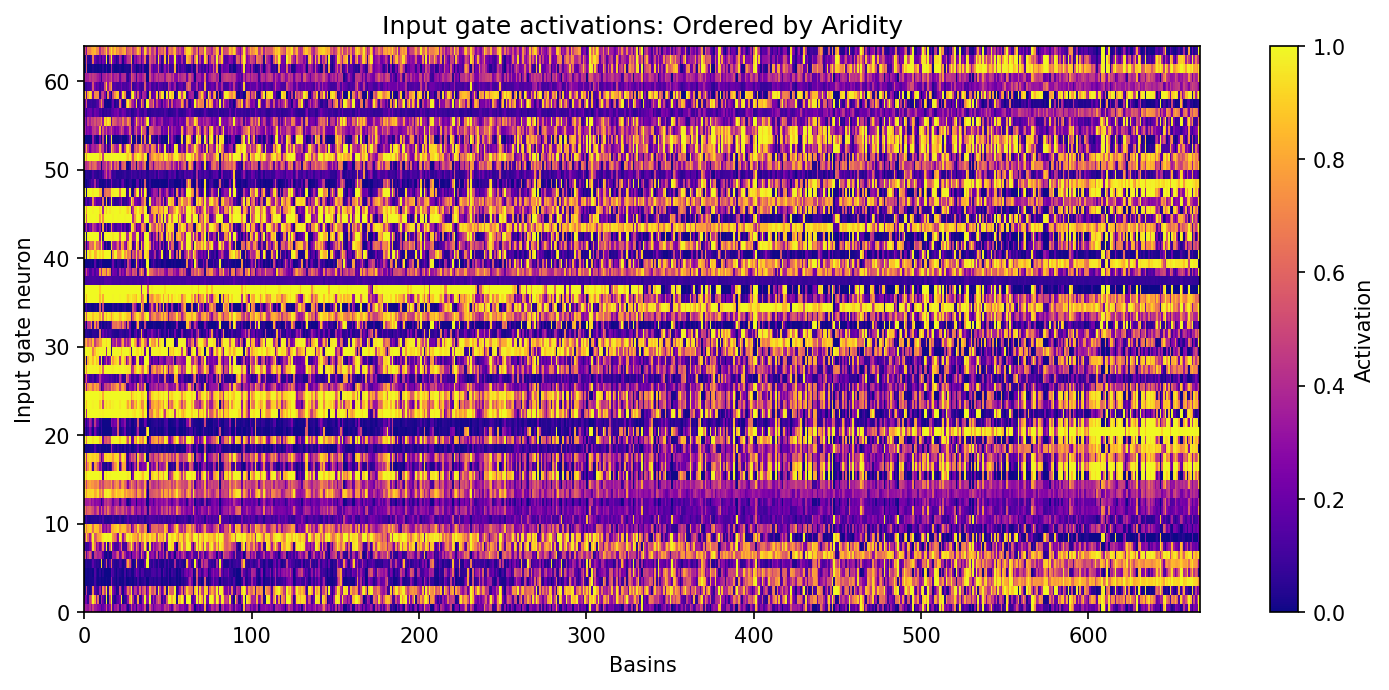

In [150]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(all_embeddings.T[:, reorder], cmap='plasma')
ax.set_xlabel("Basins")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations: Ordered by Aridity")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

# Interpret Static Embeddings

In [37]:
from scripts.drafts.clusterutils import get_silhouette_scores, get_clusters, get_label_2_color, get_variance_reduction

### Cluster analysis

In [38]:
# load raw attributes and normalise
df_raw = static
df_norm = (df_raw - df_raw.mean()) / df_raw.std()

# DROP the stations with missing data
df_norm = df_norm[np.isin(df_norm.index, VALID_BASINS)]
raw_features = df_norm.values

# Check that the order of basins is the same in embedding / static
assert all([str(si) == ORDER[ix] for ix, si in enumerate(df_norm.index)])

### silhouette scores

In [39]:
f1 = (data_dir / "RUNOFF/lstm_silhouette_scores_means.pkl")
f2 = (data_dir / "RUNOFF/lstm_silhouette_scores_mins.pkl")

if (not f1.exists()) & (not f2.exists()):
    print("==> Calculate mean/min silhouette scores for the EA-LSTM embedding")
    lstm_scores_means = defaultdict(list)
    lstm_scores_mins = defaultdict(list)
    
    # for each basin embedding calc a distribution of 
    for lstm_embedding in tqdm(all_embeddings):
        stacked_embedding = lstm_embedding.reshape(-1, 1)
        mean_scores, min_scores = get_silhouette_scores(stacked_embedding)
        for cluster, values in mean_scores.items():
            lstm_scores_means[cluster].append(values)
        for cluster, values in min_scores.items():
            lstm_scores_mins[cluster].append(values)

    with f1.open("wb") as f:
        pickle.dump(lstm_scores_means, f)
    with f2.open("wb") as f:
        pickle.dump(lstm_scores_mins, f)

else:
    lstm_scores_means = pickle.load(f1.open("rb"))
    lstm_scores_mins = pickle.load(f2.open("rb"))

In [40]:
f1 = (data_dir / "RUNOFF/raw_silhouette_scores_means.pkl")
f2 = (data_dir / "RUNOFF/raw_silhouette_scores_mins.pkl")

if (not f1.exists()) & (not f2.exists()):
    print("==> Calculate mean/min silhouette scores for the raw catchment attributes")
    raw_scores_means, raw_scores_mins = get_silhouette_scores(raw_features)
    with f1.open("wb") as f:
        pickle.dump(raw_scores_means, f)
    with f2.open("wb") as f:
        pickle.dump(raw_scores_mins, f)
else:
    raw_scores_means = pickle.load(f1.open("rb"))
    raw_scores_mins = pickle.load(f2.open("rb"))

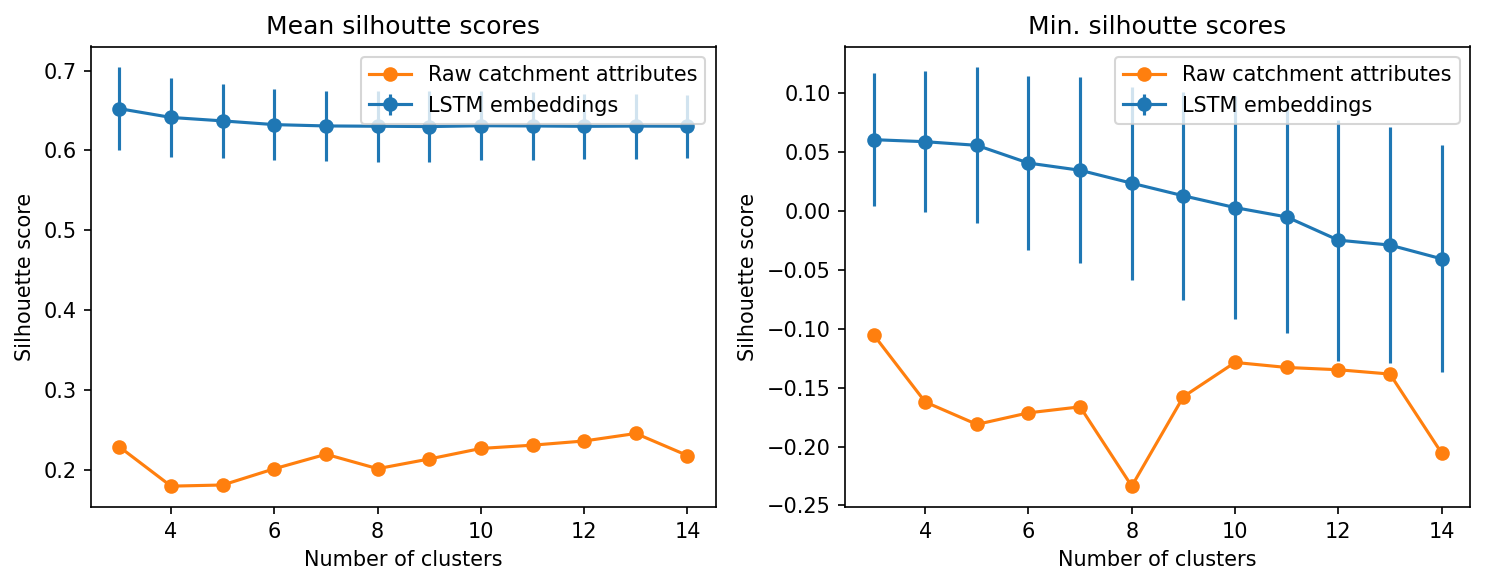

In [41]:
# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

# plot 
ax[0].errorbar(x=list(lstm_scores_means.keys()), 
            y=[np.mean(vals) for vals in list(lstm_scores_means.values())],
            yerr = [np.std(vals) for vals in list(lstm_scores_means.values())],
            marker='o', 
            markevery=1,
            label="LSTM embeddings")

# plot raw scores
ax[0].plot(list(raw_scores_means.keys()), 
        list(raw_scores_means.values()), 
        marker='o', 
        markevery=1,
        label="Raw catchment attributes")

ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Mean silhoutte scores")
ax[0].legend()

#
ax[1].errorbar(x=list(lstm_scores_mins.keys()), 
            y=[np.mean(vals) for vals in list(lstm_scores_mins.values())],
            yerr = [np.std(vals) for vals in list(lstm_scores_mins.values())],
            marker='o', 
            markevery=1,
            label="LSTM embeddings")

# plot raw scores
ax[1].plot(list(raw_scores_mins.keys()), 
        list(raw_scores_mins.values()), 
        marker='o', 
        markevery=1,
        label="Raw catchment attributes")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Min. silhoutte scores")
ax[1].legend()
plt.tight_layout()

### K Means Clustering

In [90]:
from sklearn.cluster import KMeans
embeddings = dict(zip([int(s) for s in ORDER], all_embeddings))
basins = [int(s) for s in ORDER]

### DEFINE NUMBER OF CLUSTERS (pick 2) ###
ks = [9, 10]
# ---------------------------------------# 

clusters = {k: defaultdict(dict) for k in ks}
for k in ks:
    for name in ['lstm', 'raw']:
        if name == "lstm":
            features = np.array(list(embeddings.values()))
        else:
            features = raw_features
        clusterer = KMeans(n_clusters=k, random_state=0, init='k-means++',
                           n_init=200).fit(features)
        for basin in basins:
            if name == 'lstm':
                emb = embeddings[basin]
            else:
                emb = df_norm.loc[df_norm.index == int(basin)].values
            clusters[k][name][basin] = clusterer.predict(emb.reshape(1, -1))[0]

### Plot the clusters

In [91]:
# Create GeoDataFrame of clusters
all_s_df = all_static.sel(station_id=np.isin(all_static.station_id, static.index)).to_dataframe()
gauge_lats = all_s_df.loc[:,"gauge_lat"]
gauge_lons = all_s_df.loc[:,"gauge_lon"]

### Run KMEANs

In [93]:
from shapely.geometry import Point
import geopandas as gpd

clusters_dict = {}
for n_cluster in clusters.keys():
#     n_cluster = [k for k in clusters.keys()][0]

    cluster_df = pd.DataFrame(
        {
            "station_id": [k for k in clusters[n_cluster]["lstm"].keys()], 
            "lstm": [k for k in clusters[n_cluster]["lstm"].values()],
            "raw": [k for k in clusters[n_cluster]["raw"].values()],
        }
    )
    cluster_df["clusters"] = [n_cluster for _ in range(len(cluster_df))]
    cluster_df = cluster_df.set_index("station_id").join(gauge_lats).join(gauge_lons).reset_index()
    cluster_gdf = gpd.GeoDataFrame(
        cluster_df, geometry=[Point((lat, lon)) for lat, lon in zip(cluster_df["gauge_lat"], cluster_df["gauge_lon"])]
    )
    clusters_dict[n_cluster] = cluster_gdf

### PLOT Spatial Results

In [95]:
# LOAD in the UK Hi-res borders
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")

In [96]:
from typing import DefaultDict, Dict 


def get_label_2_color(cluster_df: pd.DataFrame) -> DefaultDict[str, Dict[int, str]]:
    assert all(np.isin(("lstm", "raw", "station_id"), cluster_df.columns))
    color_list = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#e6ab02', '#66a61e']
    color_list = sns.color_palette()

    # Get which basins are in each group
    basin_in_cluster = defaultdict(dict)

    lstm_groups = cluster_df.groupby("lstm")['station_id'].apply(list).to_frame()
    raw_groups = cluster_df.groupby("raw")['station_id'].apply(list).to_frame()

    # which cluster does the basin belong to (LSTM cluster)
    for group, basins in lstm_groups.iterrows():
        basin_in_cluster["lstm"][group] = basins.values[0]
    # which cluster does the basin belong to (raw cluster)
    for group, basins in raw_groups.iterrows():
        basin_in_cluster["raw"][group] = basins.values[0]

    # assign the same color to the clusters with max overlap
    label_2_color = defaultdict(dict)

    for label, basins in basin_in_cluster["lstm"].items():
        label_2_color["lstm"][label] = color_list[label]

        max_count = -1
        color_label = None
        for label2, basins2 in basin_in_cluster["raw"].items():
            intersect = set(basins).intersection(basins2)
            if len(intersect) > max_count:
                max_count = len(intersect)
                color_label = label2

        label_2_color["raw"][color_label] = color_list[label]
        
    # assign the missing key/color
    is_matching_keys = np.isin([k for k in label_2_color["lstm"].keys()], [k for k in label_2_color["raw"].keys()])
    if not all(is_matching_keys):
        is_missing_color = np.isin([k for k in label_2_color["lstm"].values()], [k for k in label_2_color["raw"].values()])
        missing_keys = np.array([k for k in label_2_color["lstm"].keys()])[~is_matching_keys]
        missing_colors = np.array([k for k in label_2_color["lstm"].values()])[~is_missing_color]
        
        for missing_key, missing_color in zip(missing_keys, missing_colors):
            label_2_color["raw"][missing_key] = str(missing_color)
    
    return label_2_color

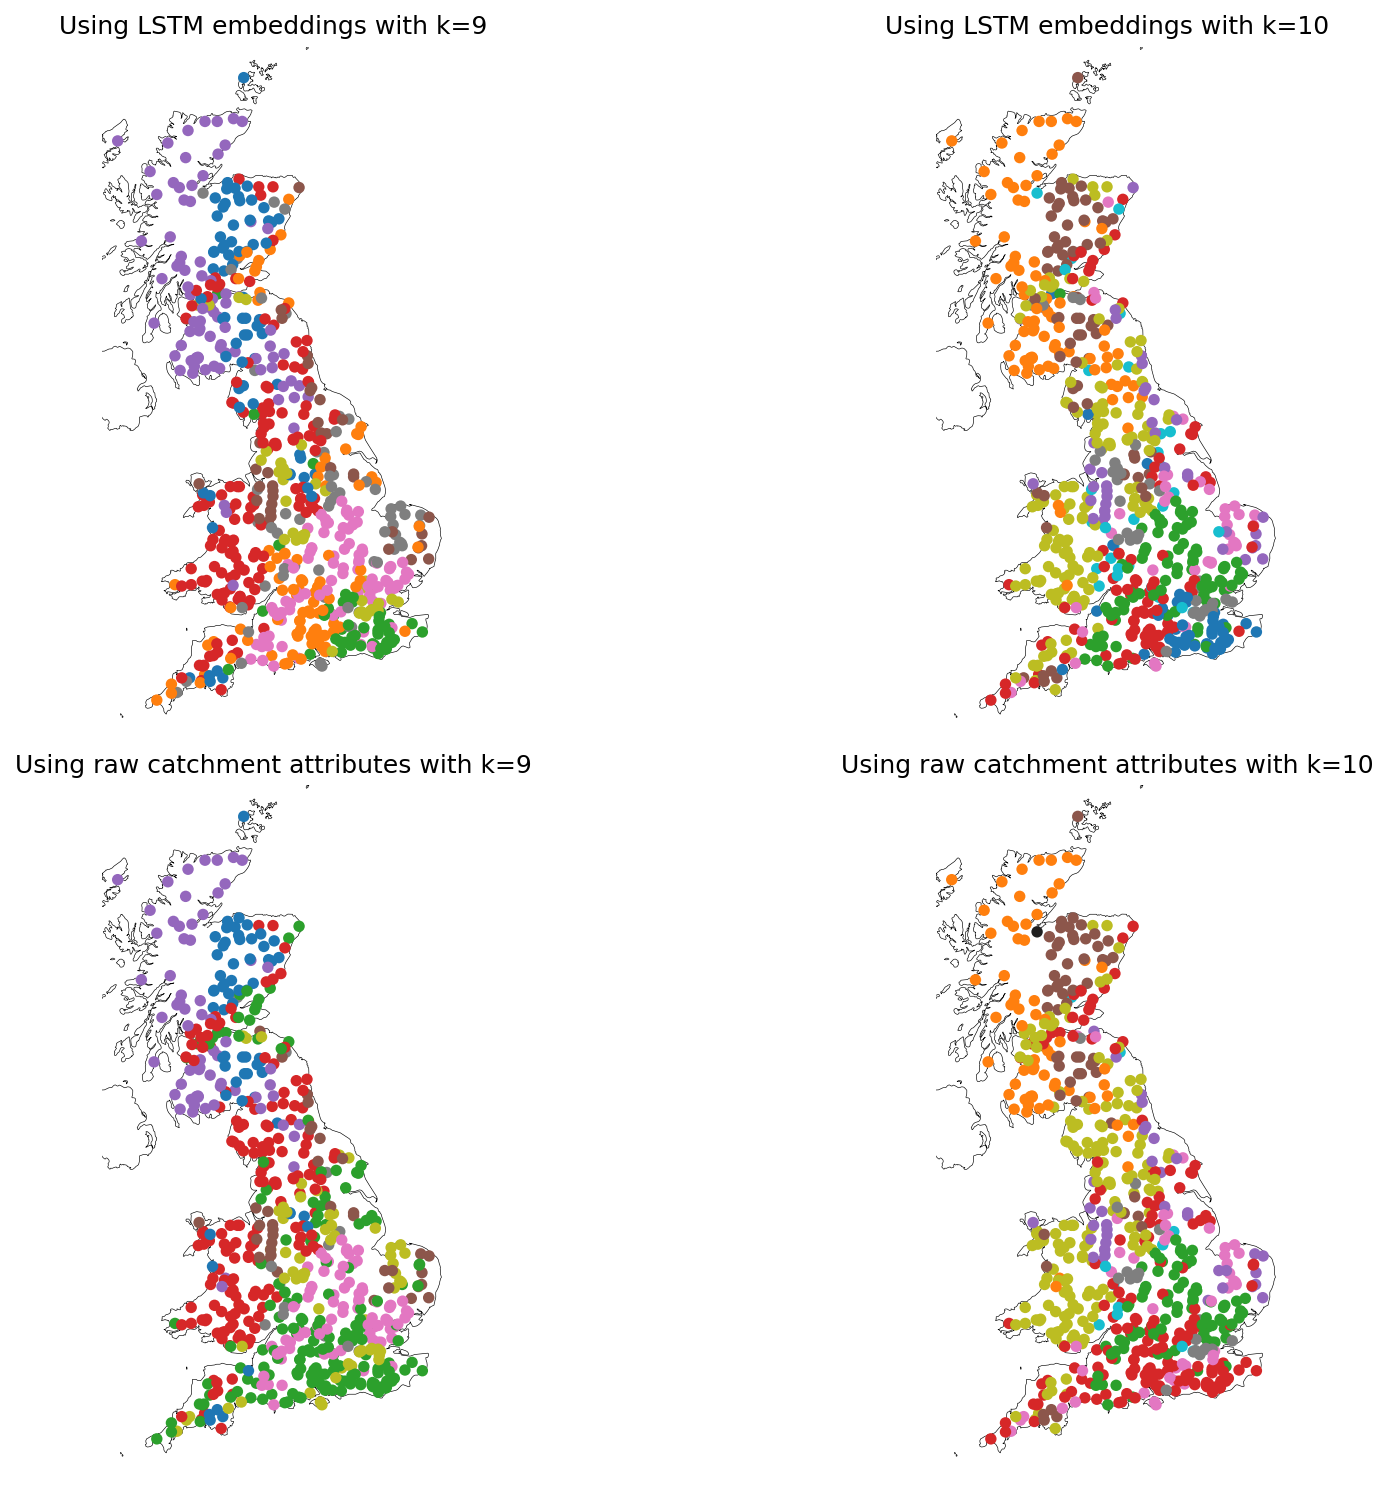

In [97]:
# draw the maps
attributes = static
plot_outline = True

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, k in enumerate(clusters.keys()):
    cluster_gdf = clusters_dict[k]
    label_2_color = get_label_2_color(cluster_gdf)
    for j, name in enumerate(clusters[k].keys()):

        data = defaultdict(list)
        for basin, label in clusters[k][name].items():
            data["lat"].append(cluster_gdf.loc[cluster_gdf["station_id"] == basin, "gauge_lat"].values)
            data["lon"].append(cluster_gdf.loc[cluster_gdf["station_id"] == basin, "gauge_lon"].values)
            data["color"].append(label_2_color[name][label])


        points = ax[j,i].scatter(x=data["lon"],
                                 y=data["lat"],
                                 c=data["color"],
                                 s=30, 
                                 zorder=2,
                                 edgecolor='none', 
                                 linewidth=0.5)
        
        if plot_outline:
            uk.plot(facecolor='none', edgecolor='k', ax=ax[j,i], linewidth=0.3)
            # ax[j,i].set_xlim([-8.19, 2.5])
            ax[j,i].set_xlim([-6.814, 1.854])
            ax[j,i].set_ylim([49.7125, 59.5575])
        
        ax[j,i].axis(False)
        if name == "lstm":
            ax[j,i].set_title(f"Using LSTM embeddings with k={k}")
        else:
            ax[j,i].set_title(f"Using raw catchment attributes with k={k}")
plt.tight_layout()

### Variance Reduction
> To test this, Fig. 10 shows the fractional reduction in variance of 13 hydrologic signatures due to clustering by both raw catchment attributes vs. by the EA-LSTM embed- ding layer. Ideally, the within-cluster variance of any partic- ular hydrological signature should be as small as possible, so that the fractional reduction in variance is as large (close to one) as possible. In both the k = 5 and k = 6 cluster exam- ples, clustering by the EA-LSTM embedding layer reduced variance in the hydrological signatures by more or approxi- mately the same amount as by clustering on the raw catch- ment attributes.

> This indicates that the EA-LSTM embedding layer largely preserves the information content about hydrological behav- iors while overall increasing distinctions between groups of similar catchments. The EA-LSTM was able to learn about hydrologic similarity between catchments by directly train- ing on both catchment attributes and rainfall–runoff time se- ries data.

In [98]:
# Get a dataframe containing the hyd. signatures per basin
q_feats = ['q_mean', 'runoff_ratio', 'stream_elas', 'slope_fdc',
    'baseflow_index', 'hfd_mean', 'Q5', 'Q95', 'high_q_freq', 'high_q_dur', 'low_q_freq',
    'low_q_dur', 'zero_q_freq']

df_q = all_static[q_feats].to_dataframe()

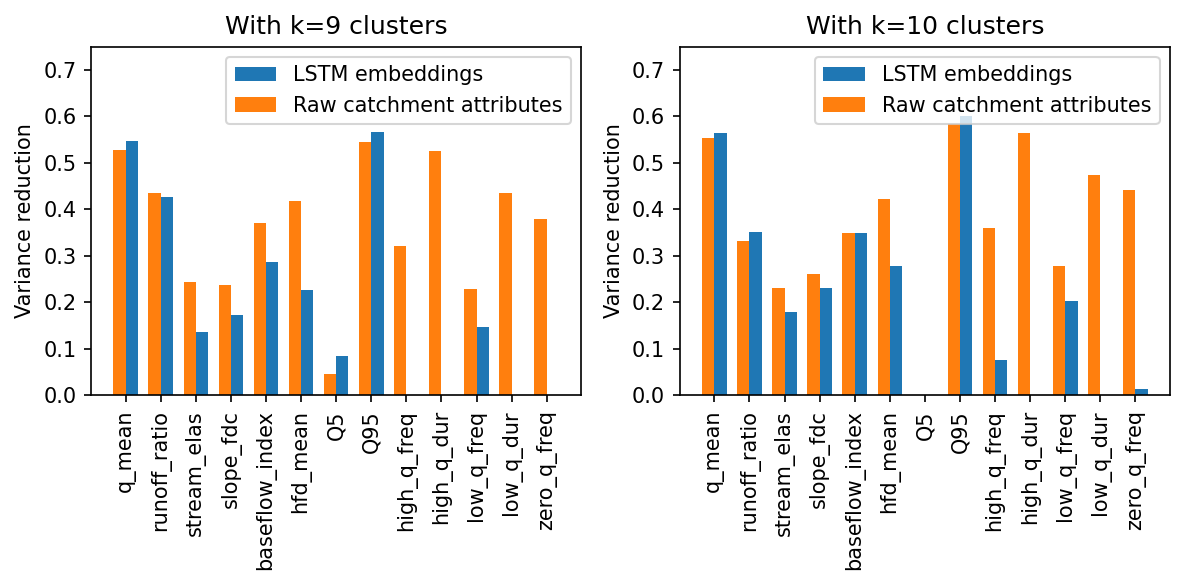

In [99]:
# Calculate and plot the results
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
for i, k in enumerate(ks):
    var_reduction = get_variance_reduction(clusters[k]["lstm"], clusters[k]["raw"], df_q)
    raw_vals = pd.concat([s for s in var_reduction["raw"].values()], axis=1).mean(axis=1)
    lstm_vals = pd.concat([s for s in var_reduction["lstm"].values()], axis=1).mean(axis=1)
    ind = np.arange(len(raw_vals))  # the x locations for the groups
    width = 0.35  # the width of the bars
    rects2 = ax[i].bar(ind + width/2, 1 - lstm_vals.values, width, 
                    label='LSTM embeddings')
    rects1 = ax[i].bar(ind - width/2, 1 - raw_vals.values, width,
                    label='Raw catchment attributes')
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[i].set_ylabel('Variance reduction')
    ax[i].set_xticks(ind)
    ax[i].set_xticklabels(raw_vals.index)
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f"With k={k} clusters")
    ax[i].legend()
    ax[i].set_ylim(0,0.75)
plt.tight_layout()


### UMAP Visualisation


In [54]:
# print(sorted([d for d in all_static.data_vars]))
all_static_df = all_static.to_dataframe()

In [55]:
import umap

In [56]:
# Calculate UMAP embedding from the LSTM catchment embeddings
transformer = umap.UMAP(n_neighbors=10, 
                        min_dist=0.1, 
                        n_components=2,
                        random_state=0).fit(all_embeddings)
umap_embedding = transformer.transform(all_embeddings)

<ipython-input-57-870993408161>:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[m,n].set_xticks([], [])
<ipython-input-57-870993408161>:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[m,n].set_yticks([], [])


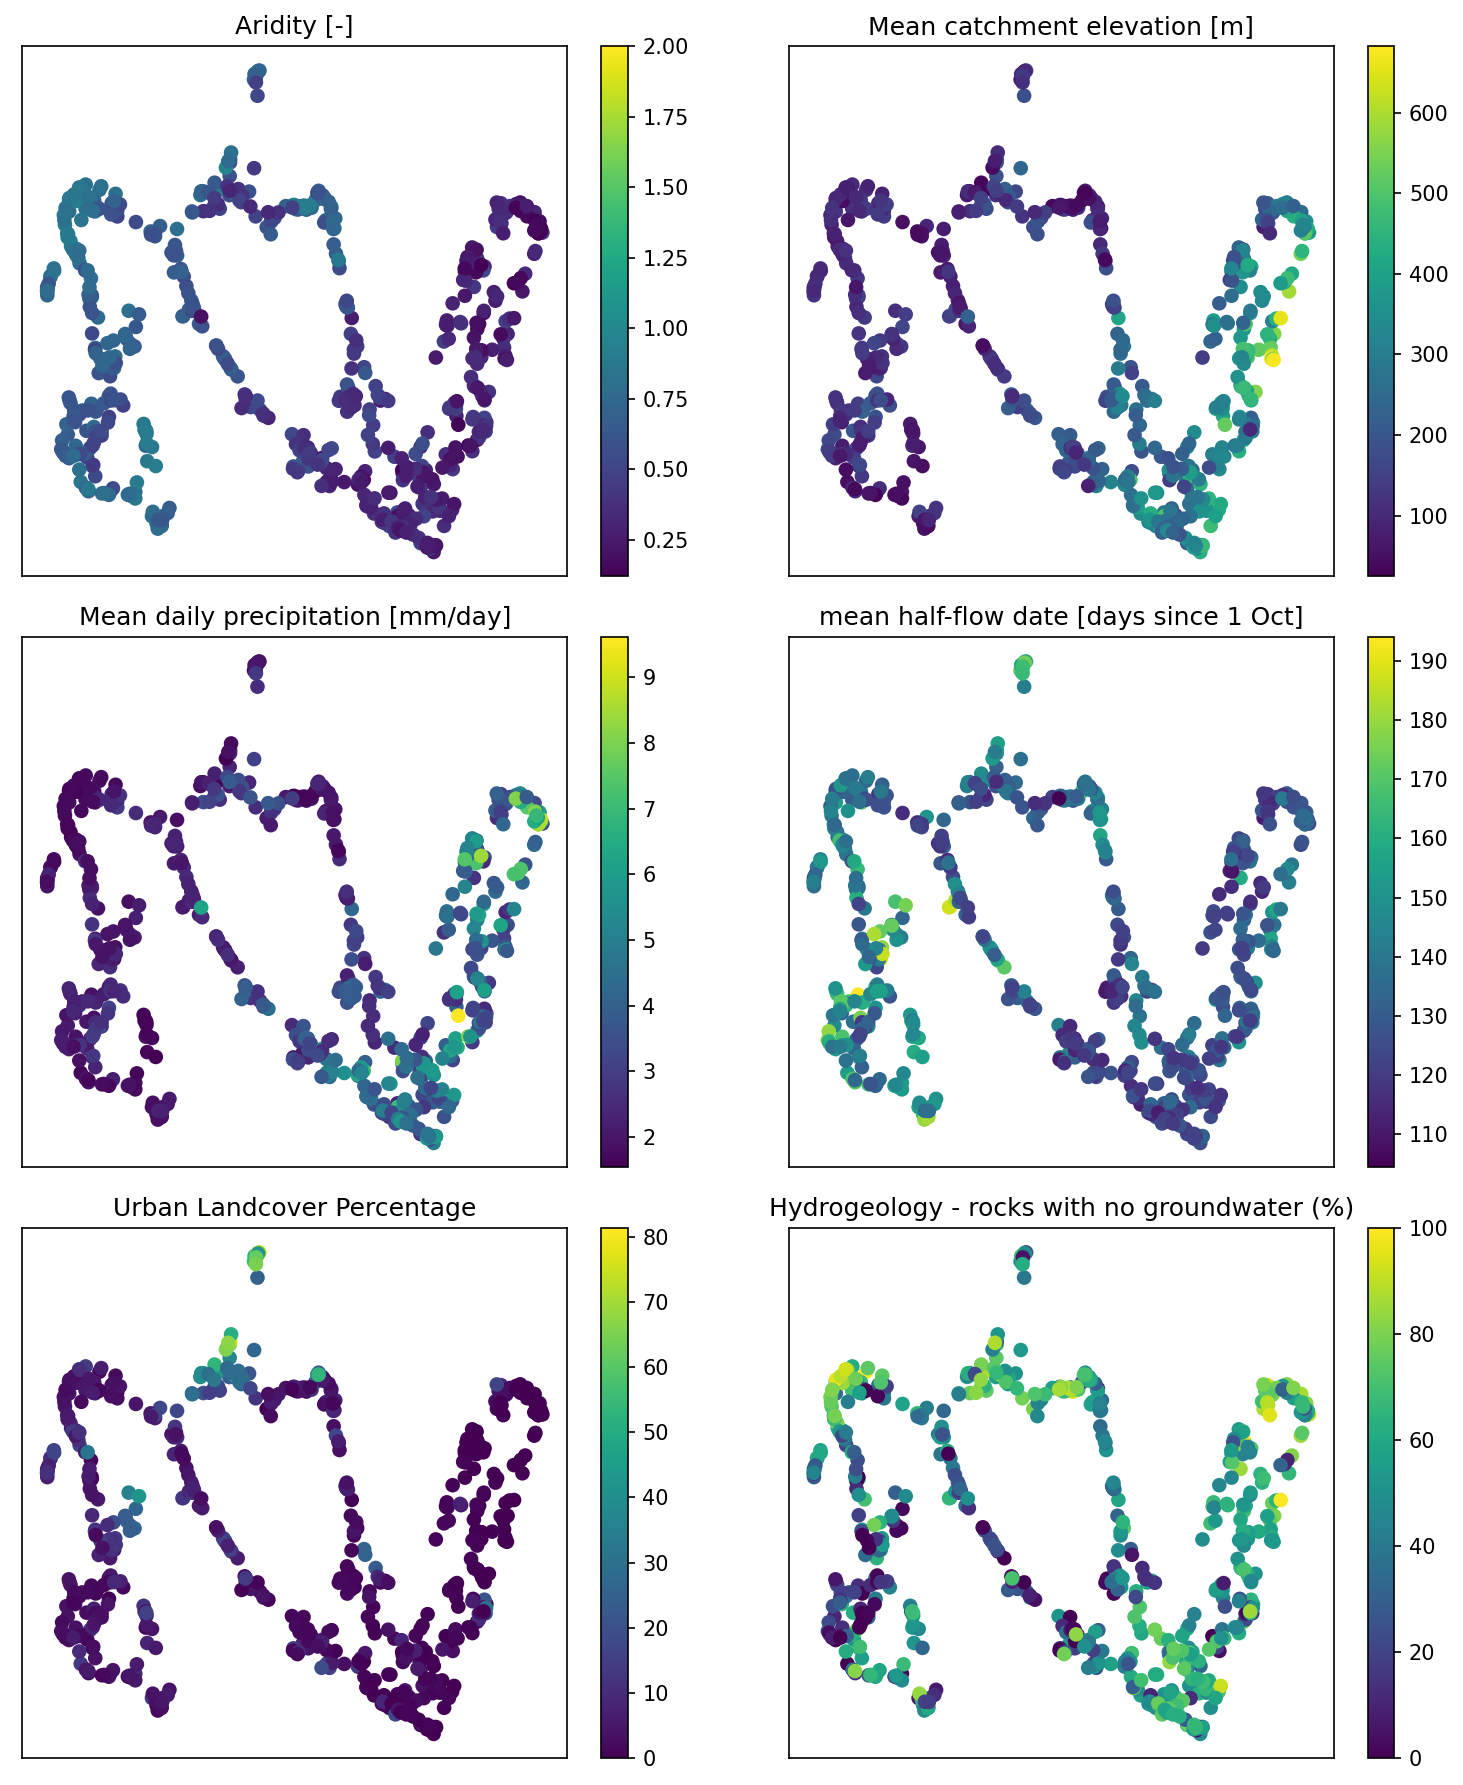

In [57]:
import matplotlib.colors as colors

# Plot the results
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10,12))

attribute_set = {'aridity': 'Aridity [-]', 
                 'elev_mean': 'Mean catchment elevation [m]', 
                 'p_mean': 'Mean daily precipitation [mm/day]', 
#                  'area': 'Catchment area [km2]', 
                 'hfd_mean': 'mean half-flow date [days since 1 Oct]', 
#                  'dpsbar': 'Mean Drainage Path Slope [m/km2]',
                 "urban_perc": "Urban Landcover Percentage",
                 "no_gw_perc": "Hydrogeology - rocks with no groundwater (%)",
                }
for i, (attribute, title) in enumerate(attribute_set.items()):
    m = i // 2
    n = i % 2
    norm = colors.Normalize(vmin=all_static_df[attribute].min(), 
                            vmax=2 if attribute == 'aridity' else all_static_df[attribute].max())
    c = []
    for basin in VALID_BASINS:
        c.append(all_static_df.loc[all_static_df.index == basin, attribute].values[0])
    
    points = ax[m,n].scatter(umap_embedding[:,0], umap_embedding[:,1], c=c, norm=norm, label="Basins")
    
    ax[m,n].set_title(title)
    ax[m,n].set_xticks([], [])
    ax[m,n].set_yticks([], [])
    plt.colorbar(points, ax=ax[m,n])
plt.tight_layout()

# [SKLEARN Silhouette Analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].
- Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
- Also from the thickness of the silhouette plot the cluster size can be visualized

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm


def run_multiple_cluster_comparisons(X):
    """
    https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
    """
    range_n_clusters = np.arange(2, 15)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()


For n_clusters = 2 The average silhouette_score is : 0.19766597
For n_clusters = 3 The average silhouette_score is : 0.21645592
For n_clusters = 4 The average silhouette_score is : 0.22363059
For n_clusters = 5 The average silhouette_score is : 0.19718409
For n_clusters = 6 The average silhouette_score is : 0.21278438
For n_clusters = 7 The average silhouette_score is : 0.22532773
For n_clusters = 8 The average silhouette_score is : 0.23409776
For n_clusters = 9 The average silhouette_score is : 0.2451014
For n_clusters = 10 The average silhouette_score is : 0.2554054
For n_clusters = 11 The average silhouette_score is : 0.23825356
For n_clusters = 12 The average silhouette_score is : 0.24529772
For n_clusters = 13 The average silhouette_score is : 0.24888512
For n_clusters = 14 The average silhouette_score is : 0.24048005


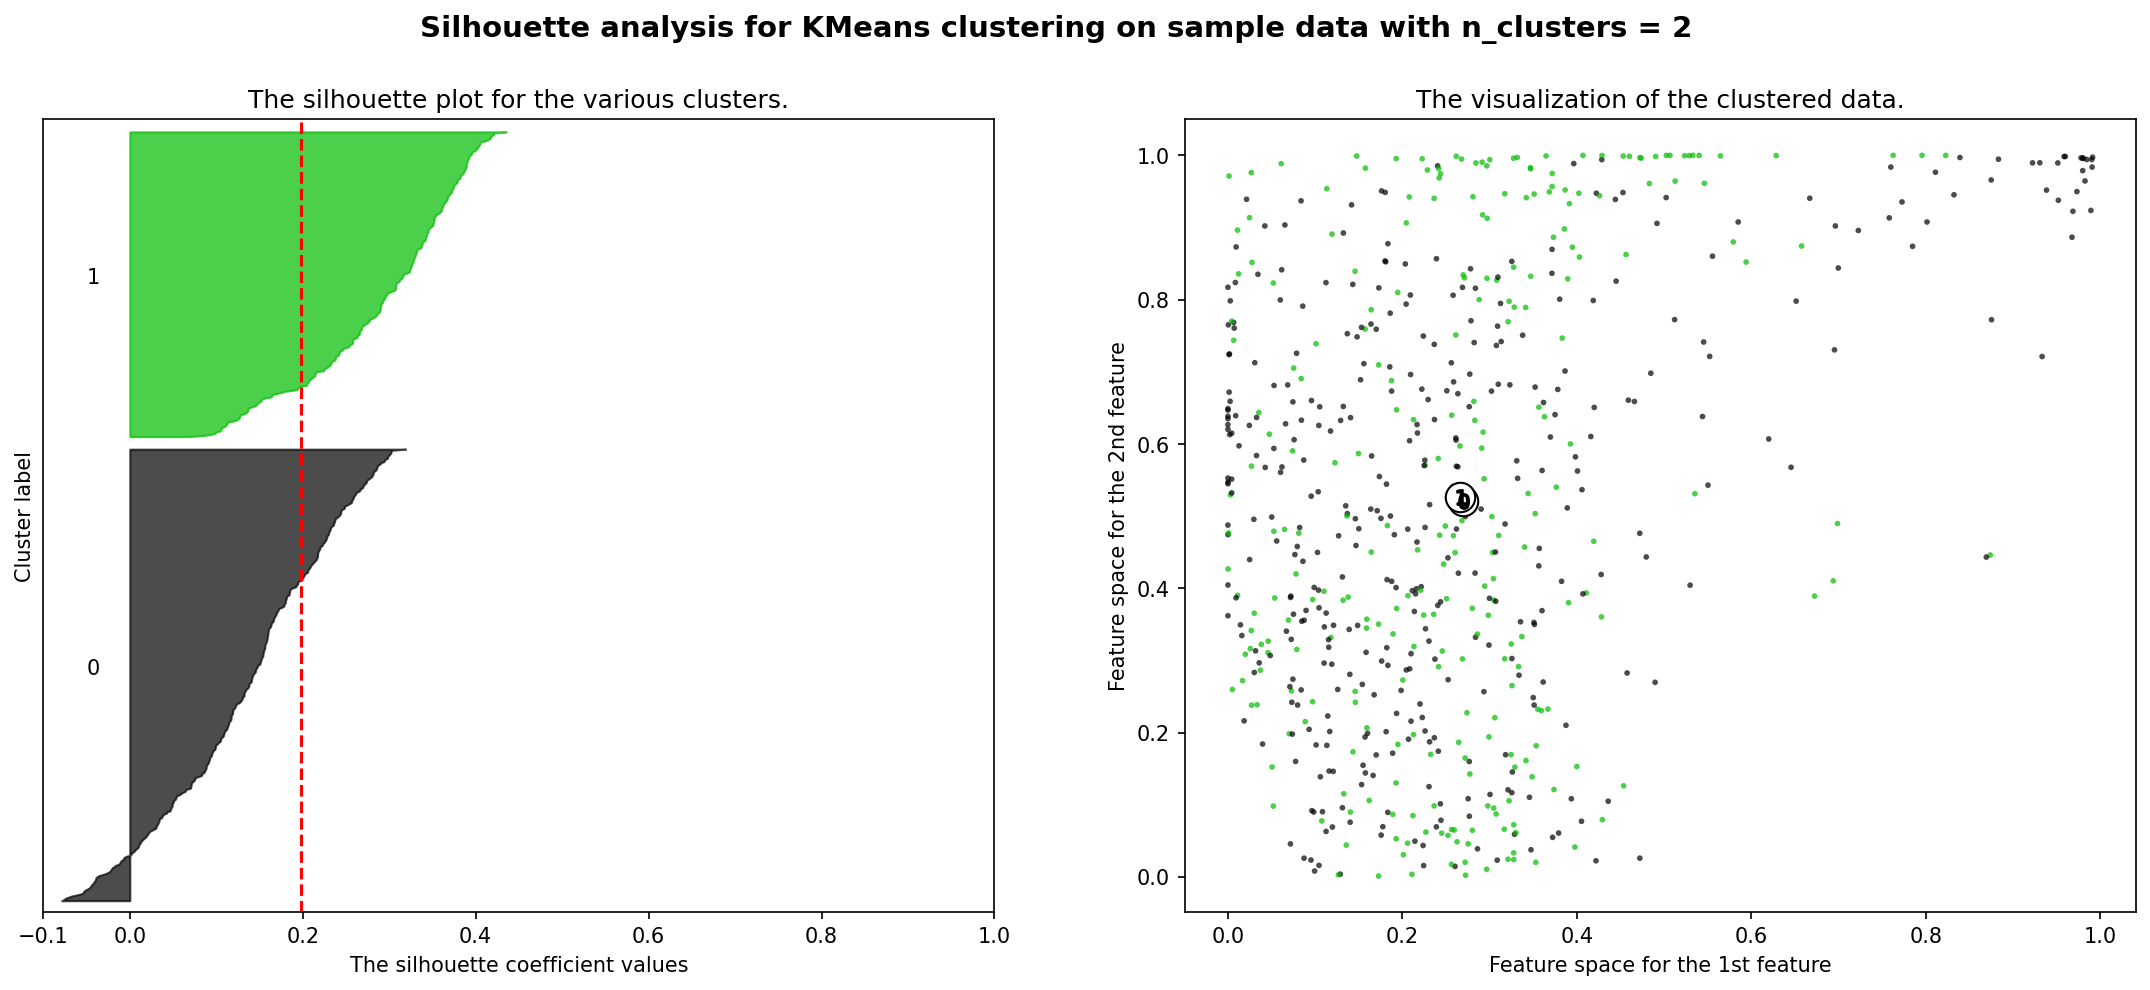

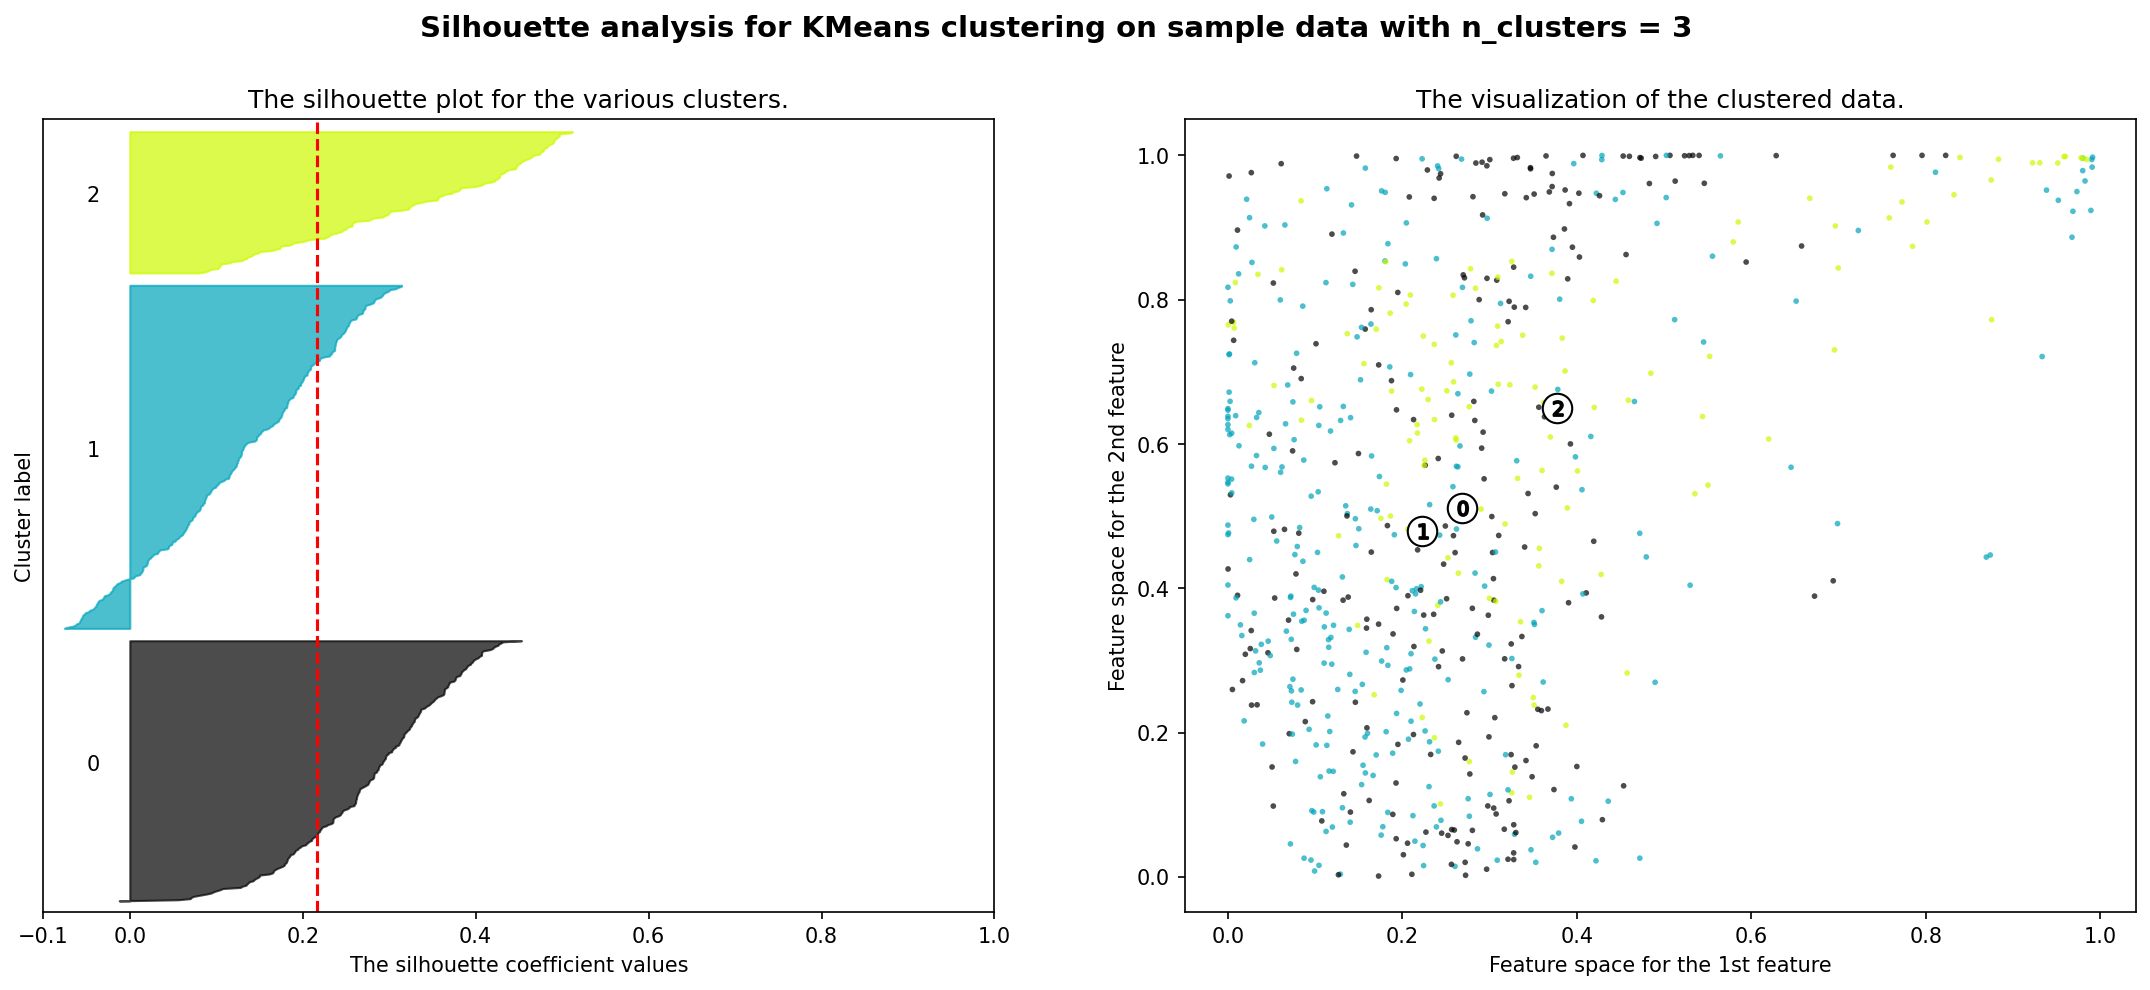

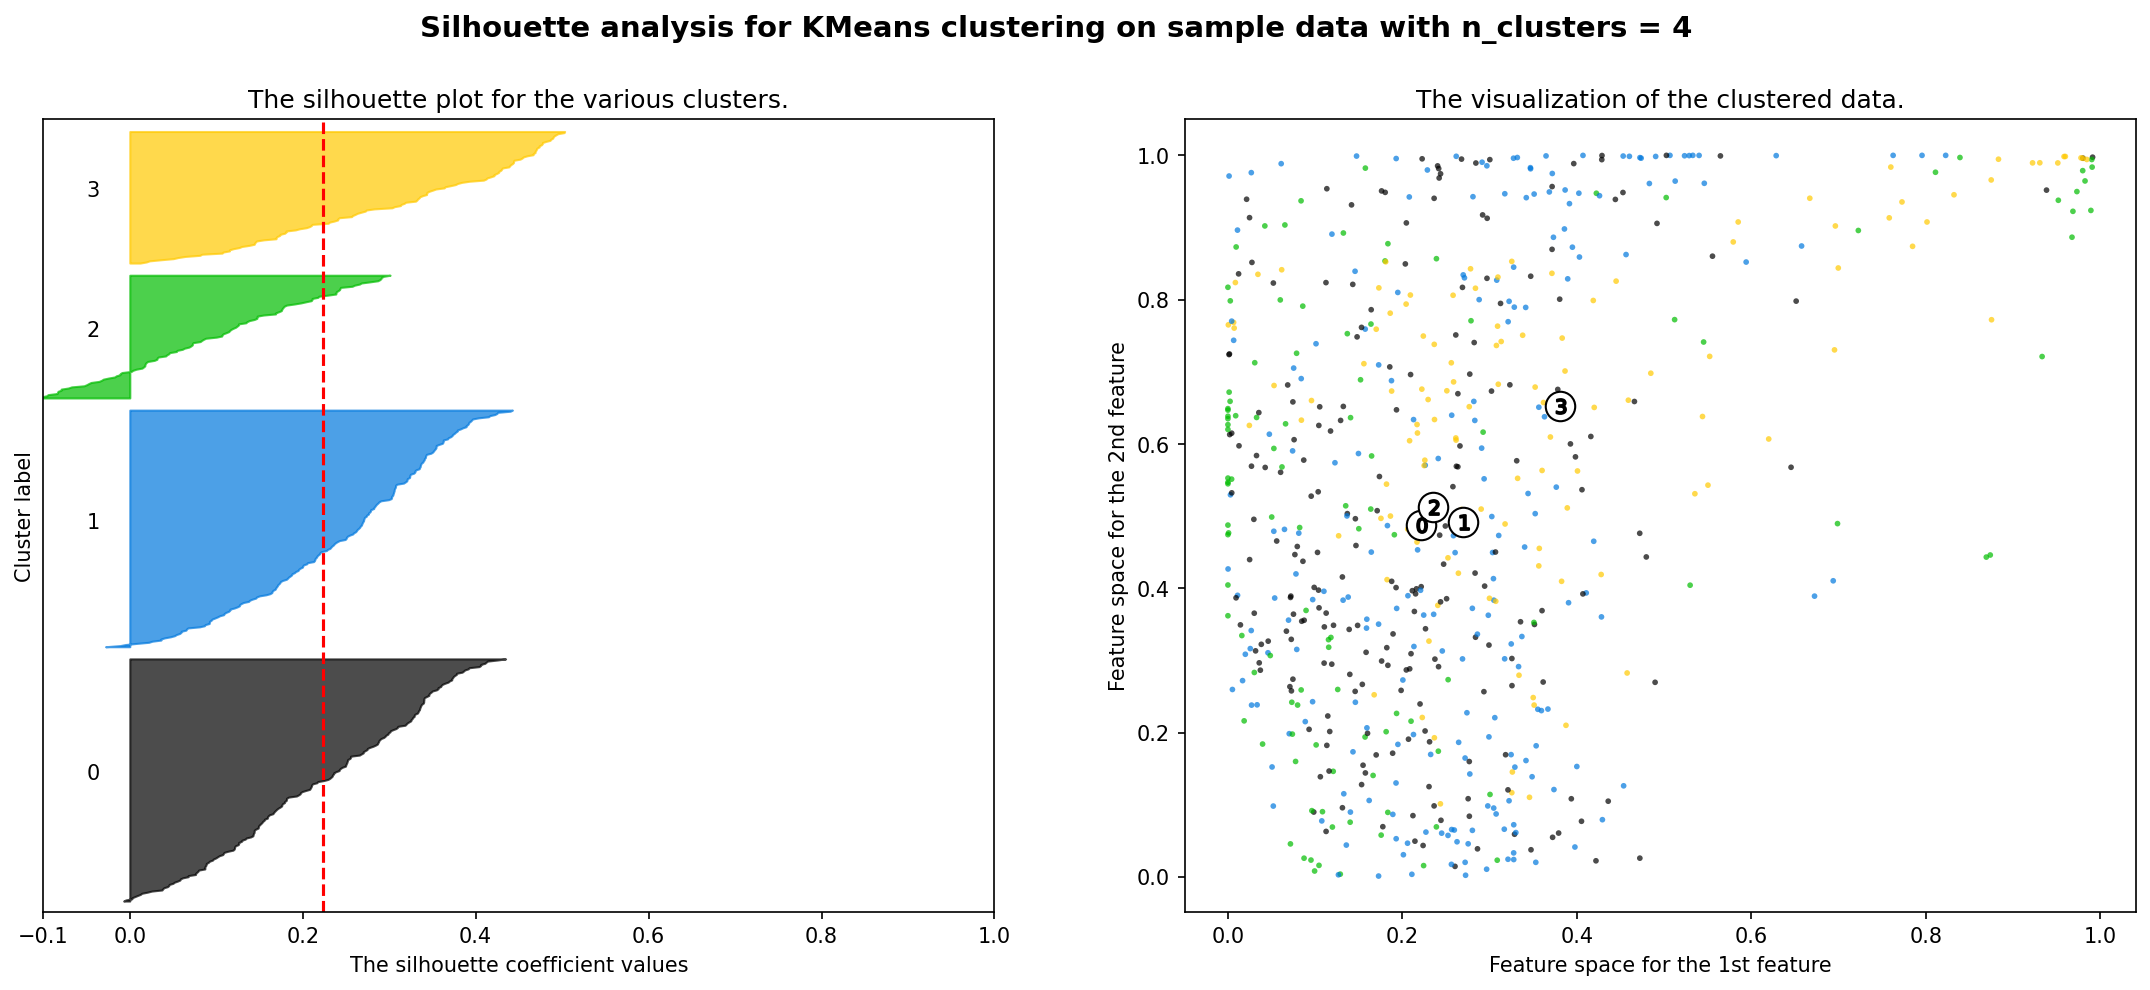

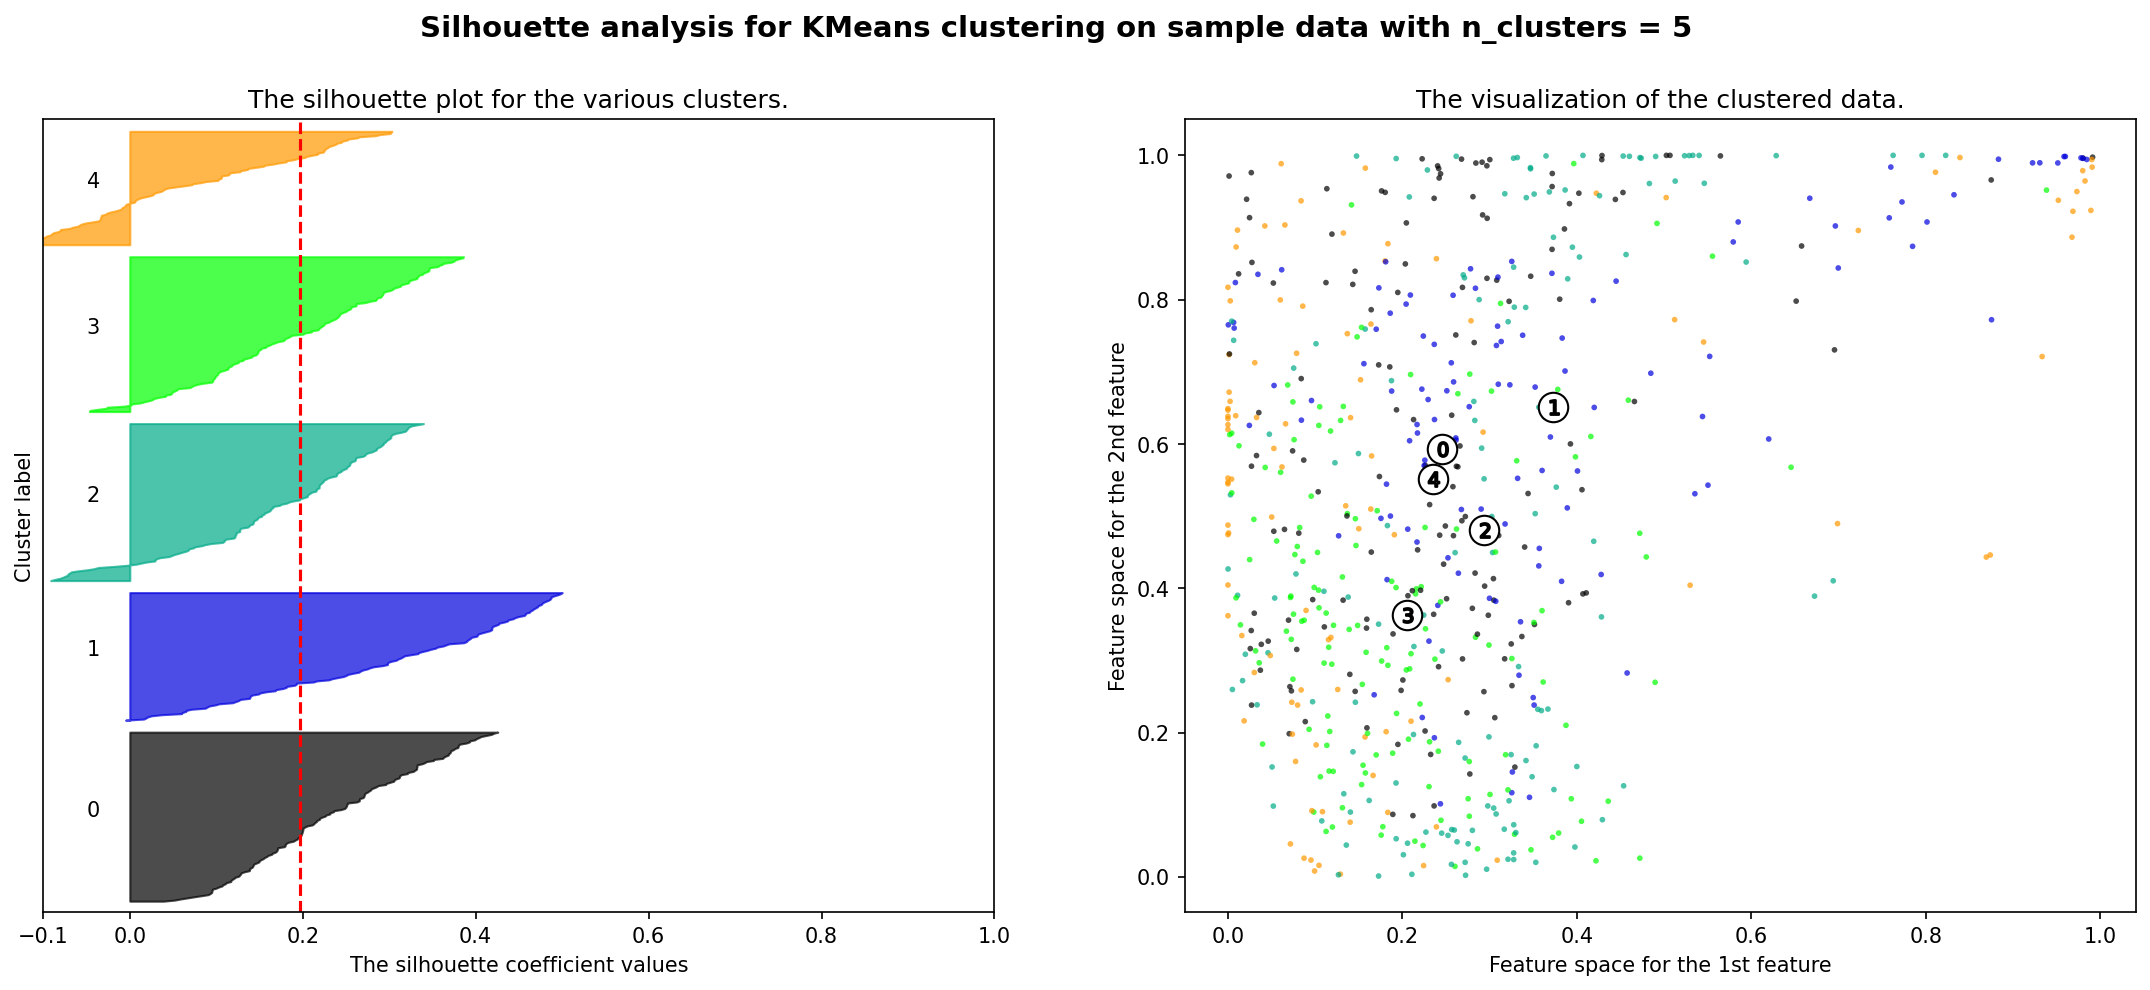

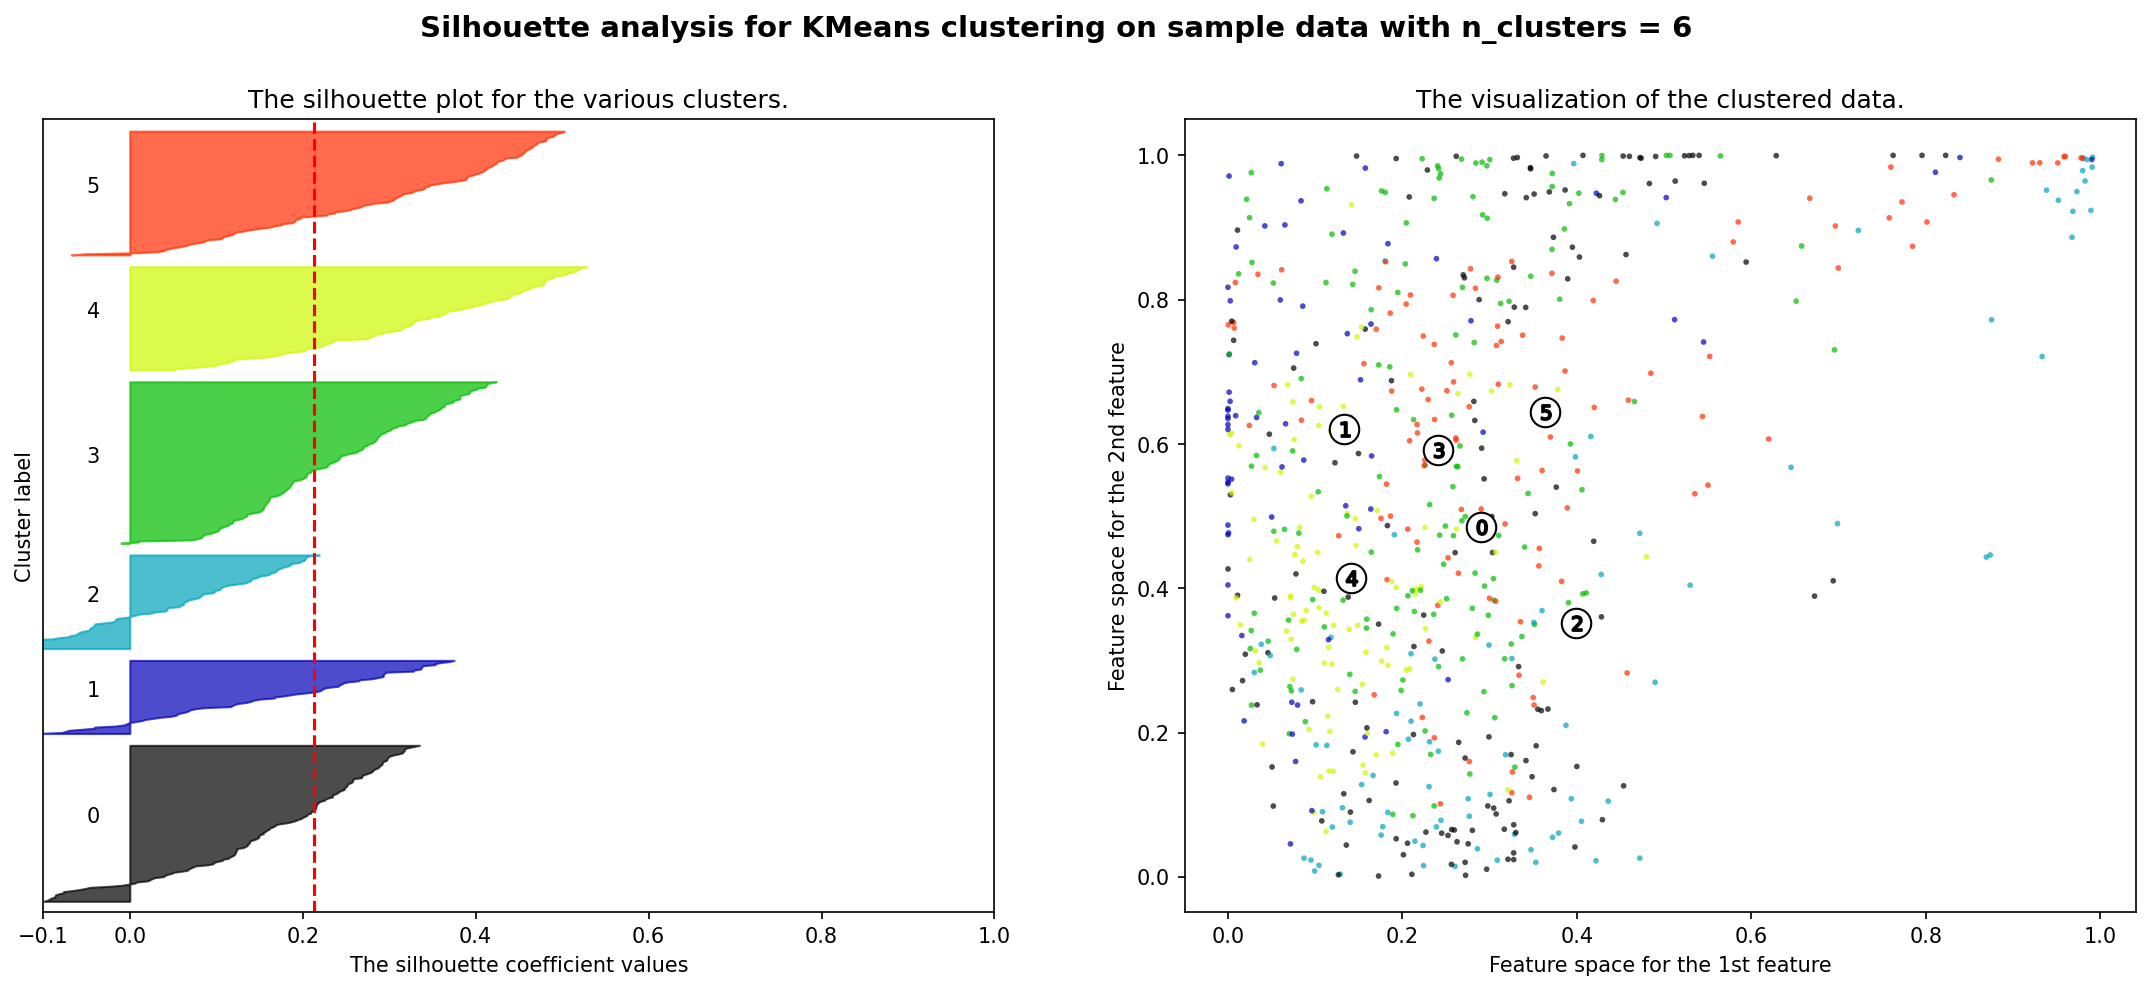

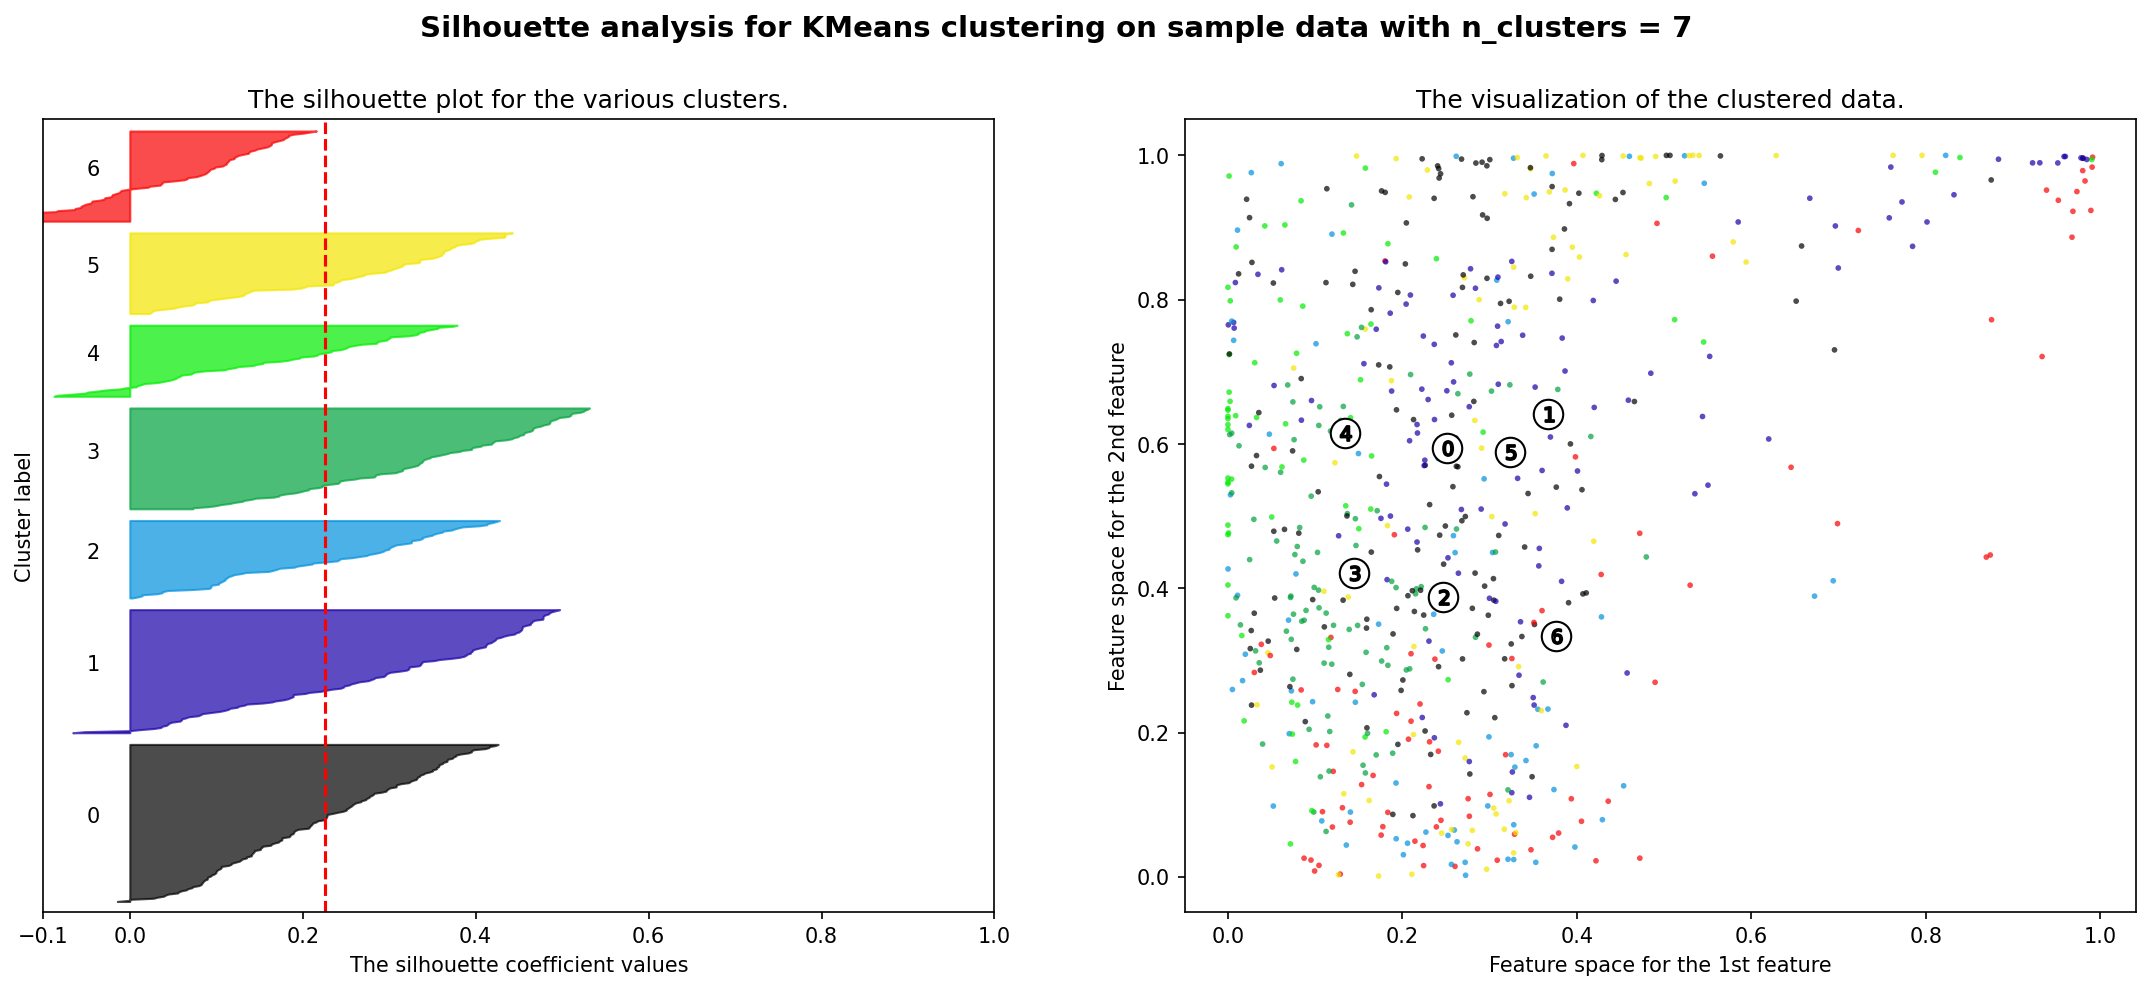

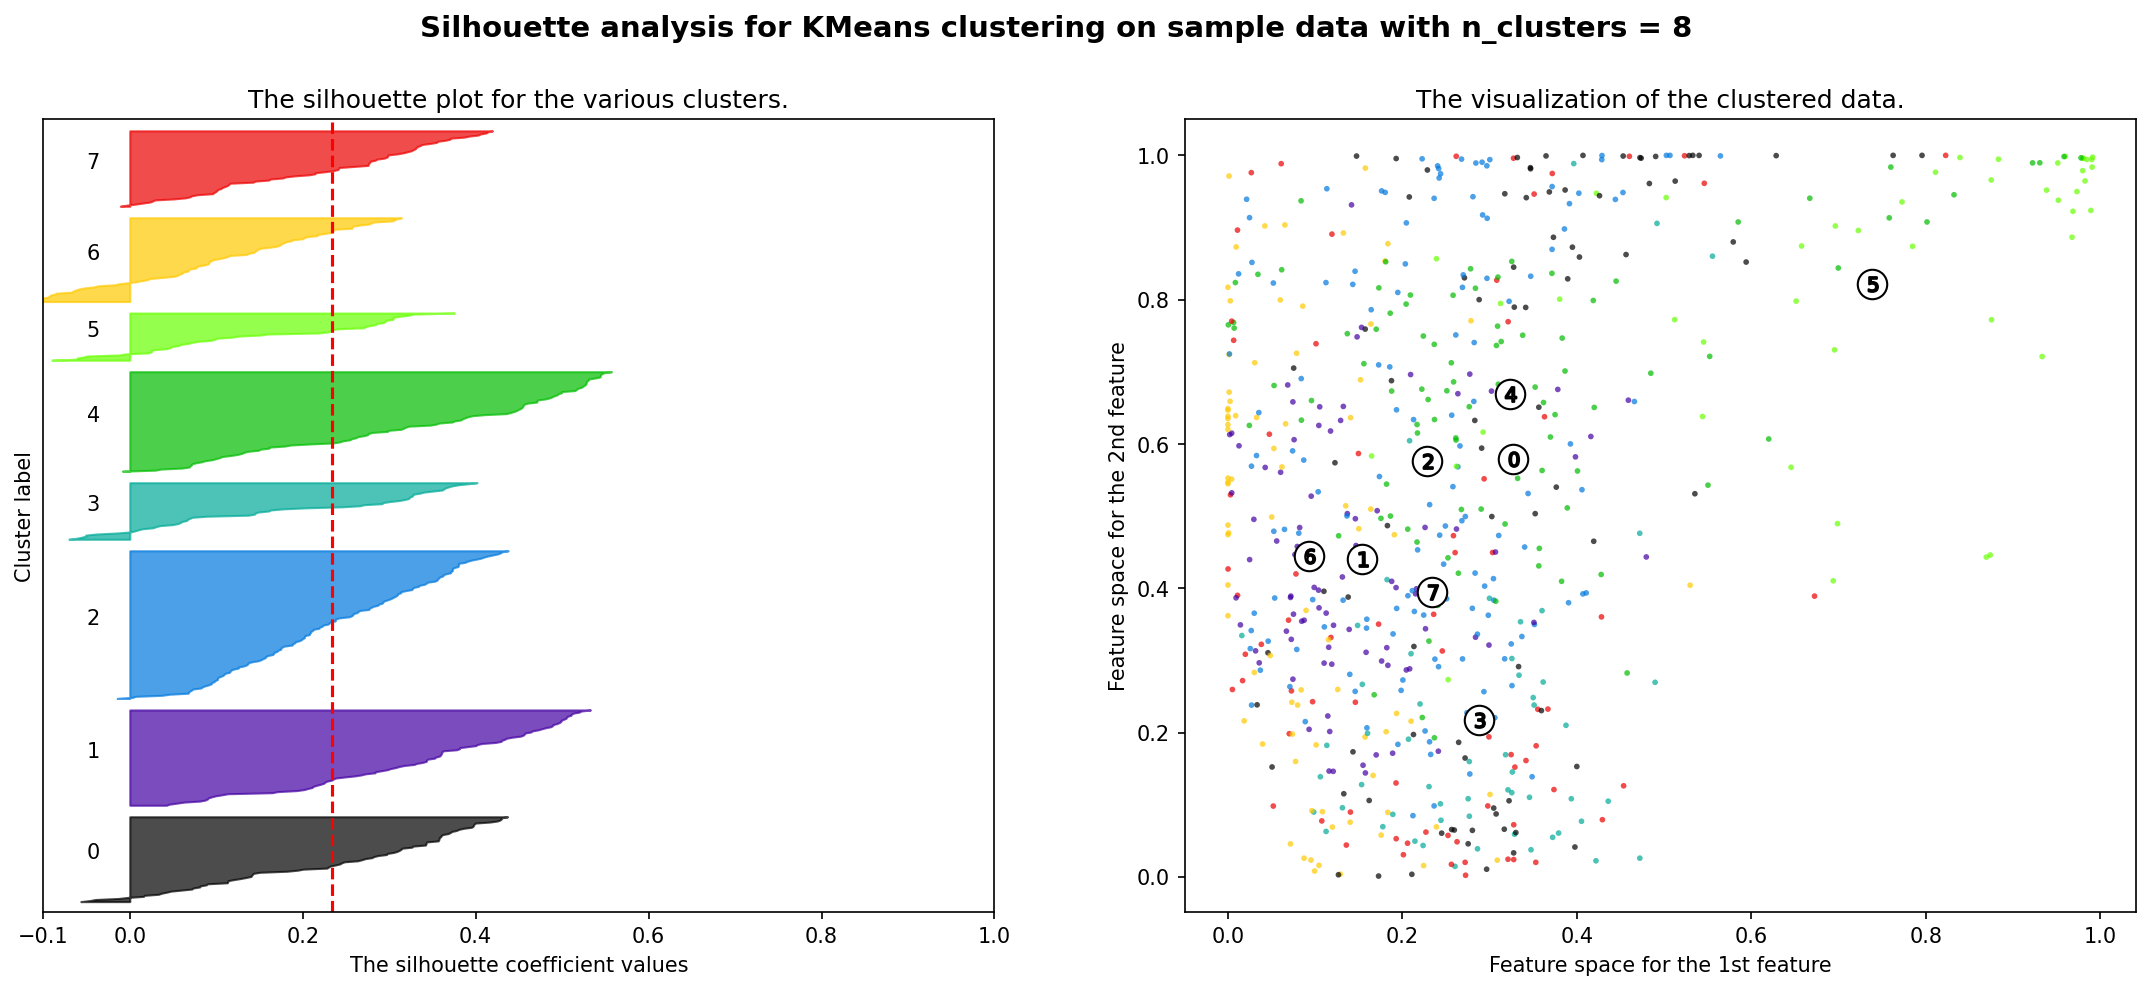

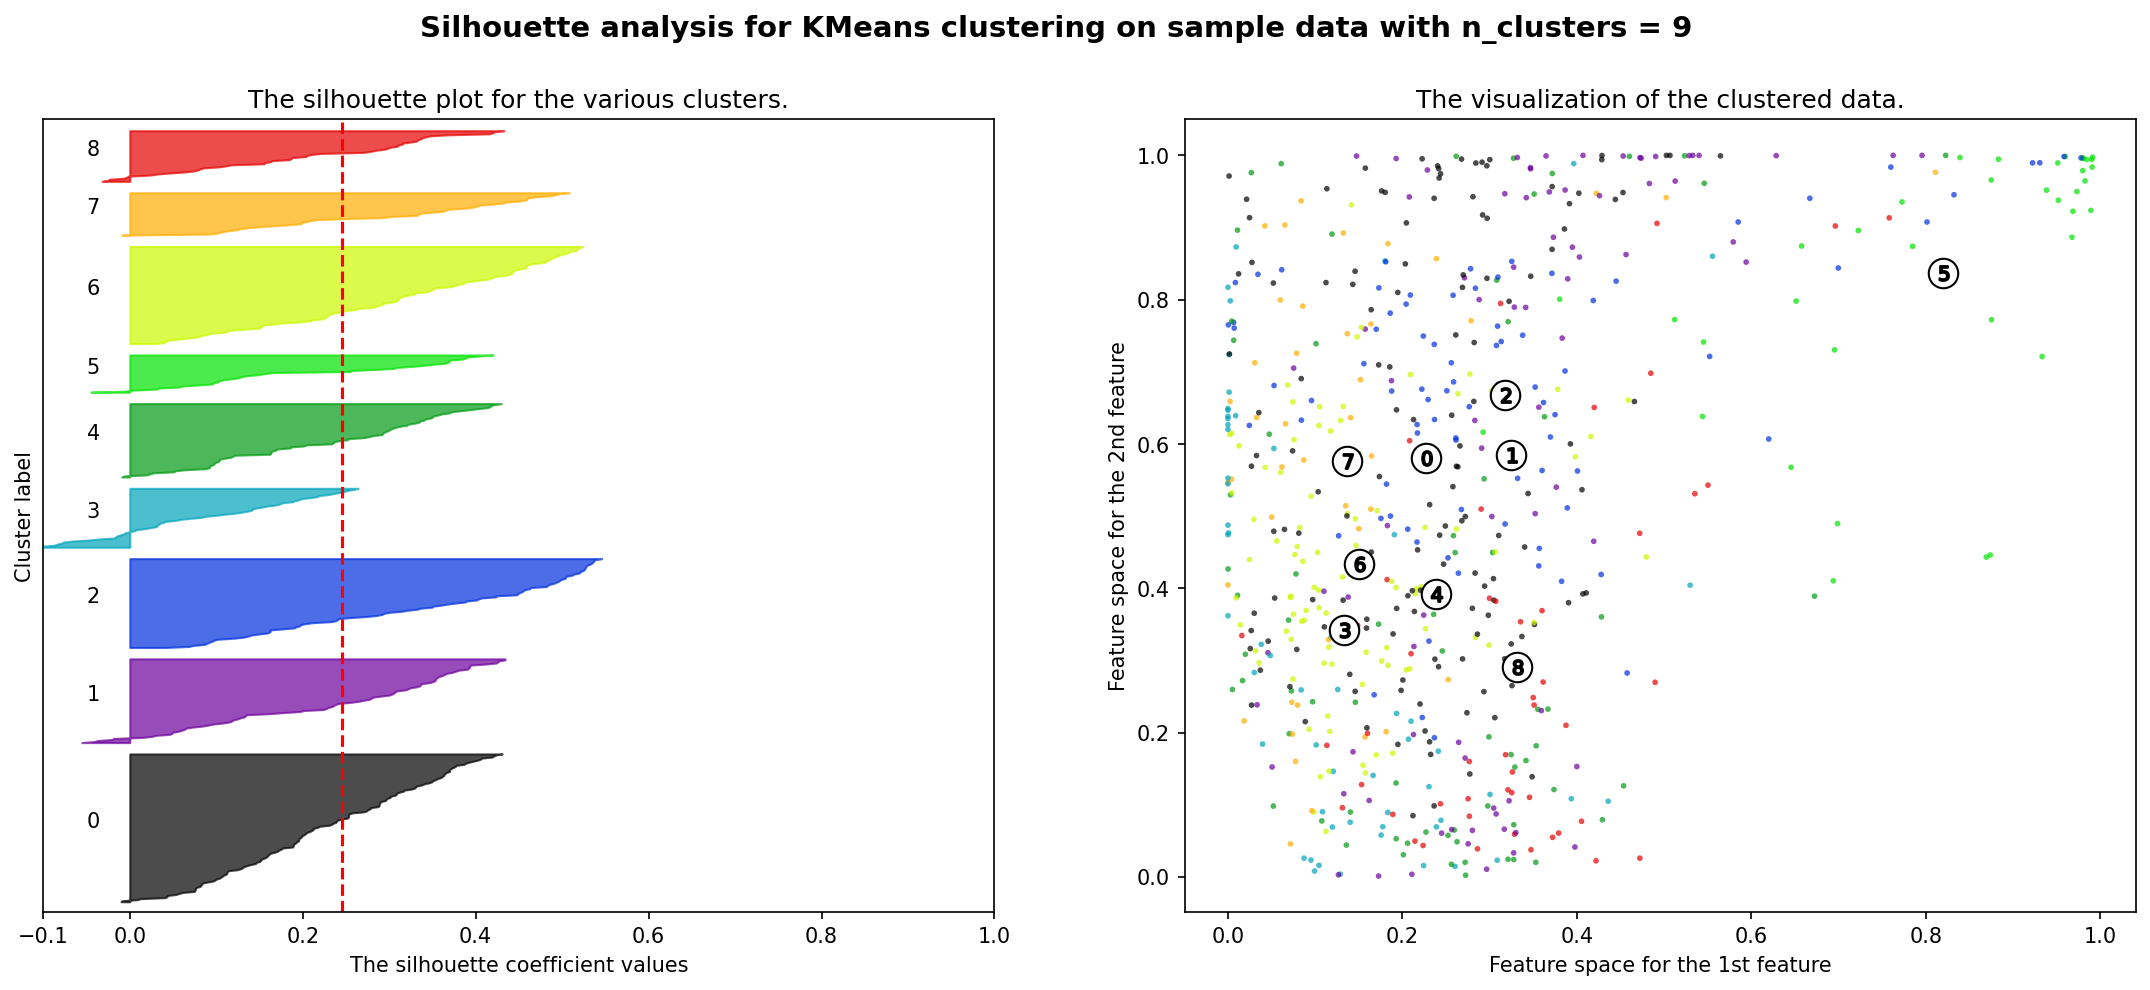

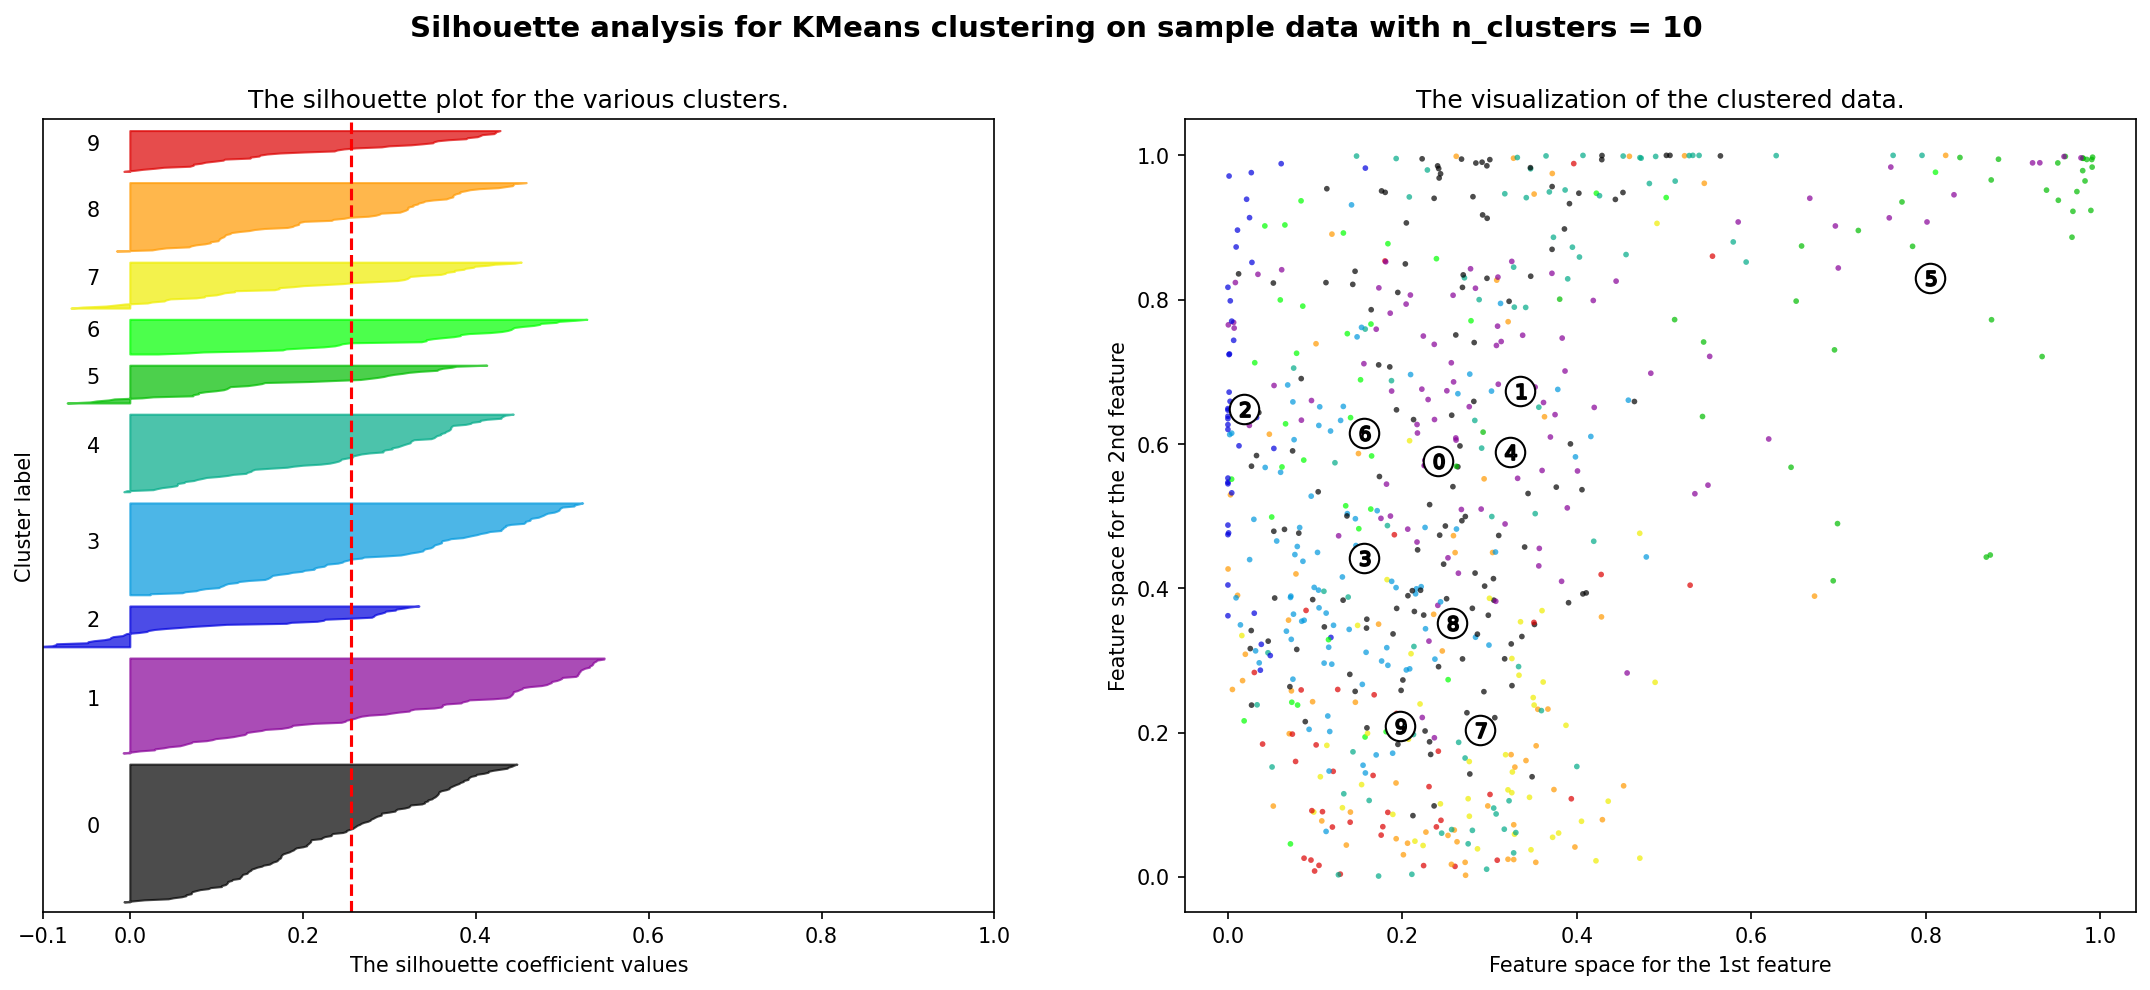

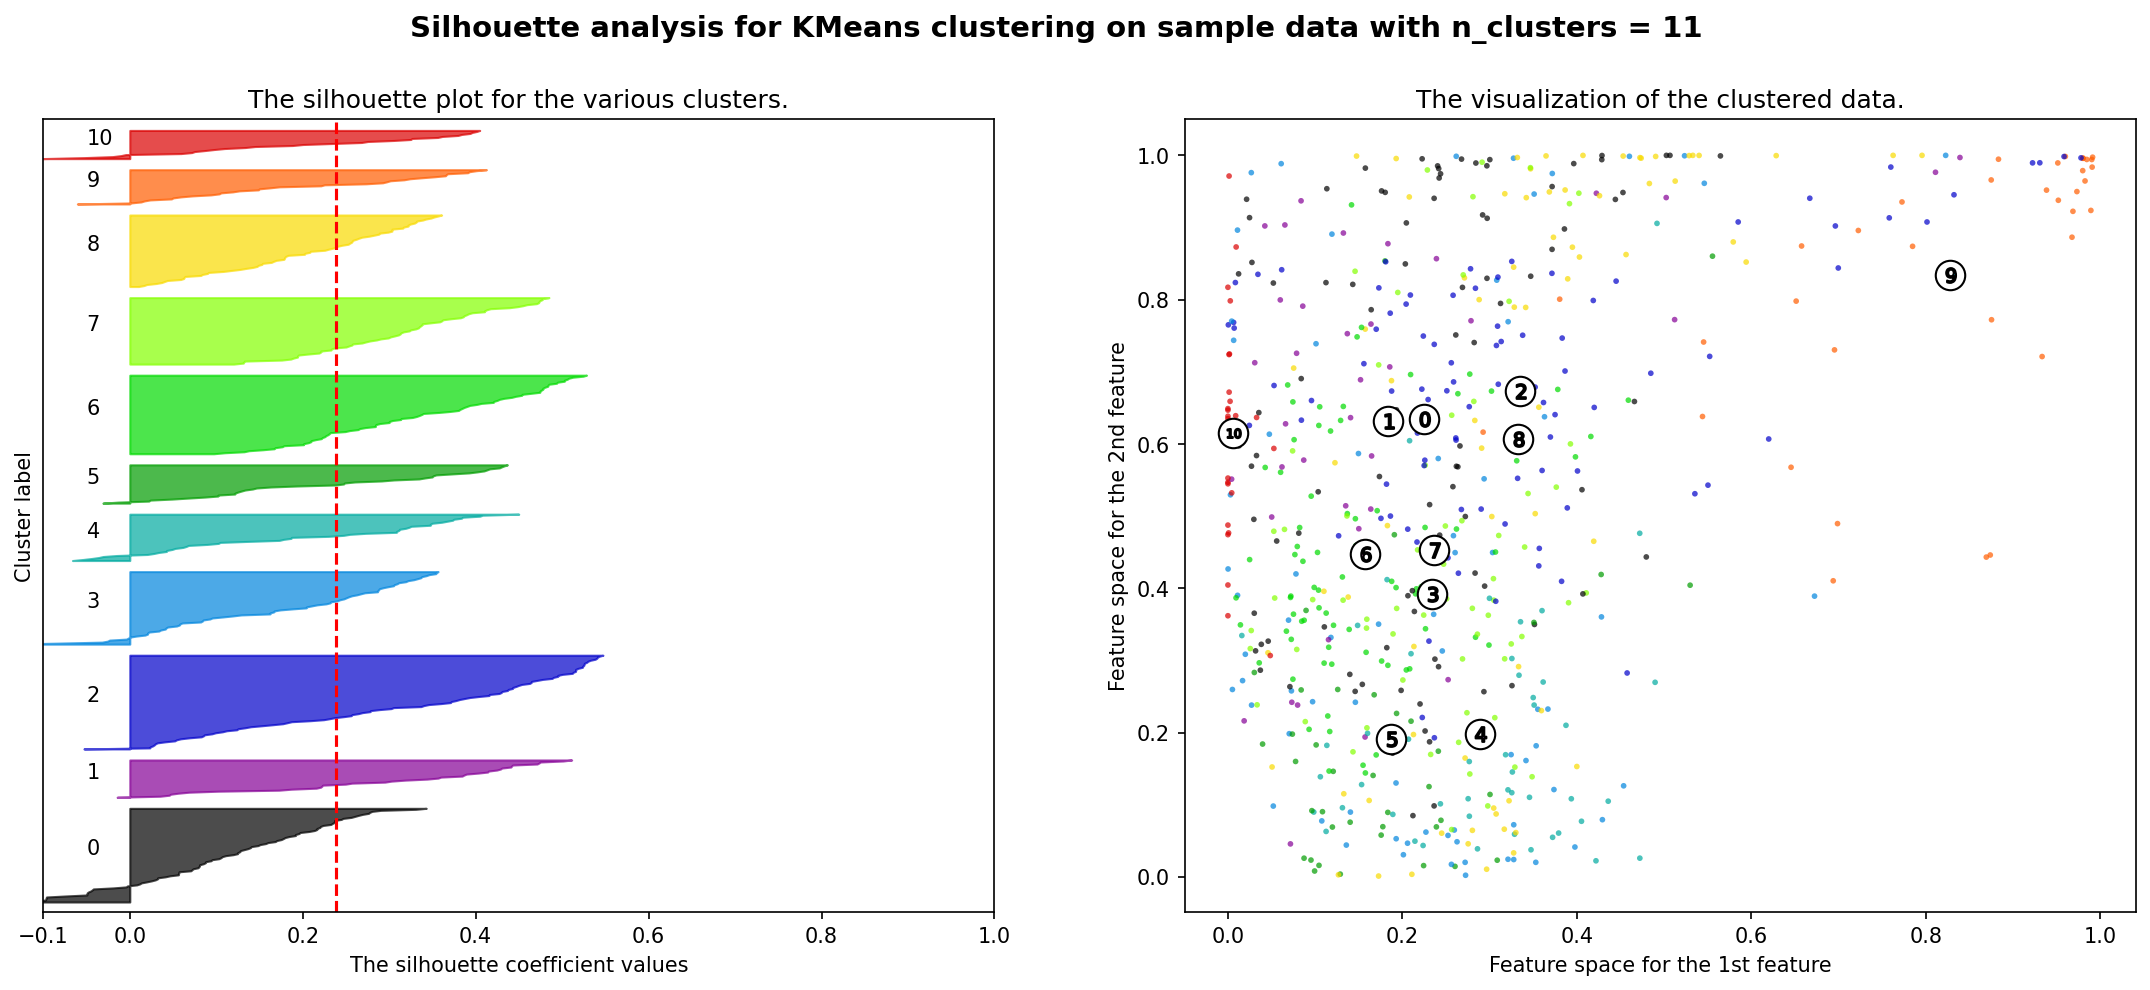

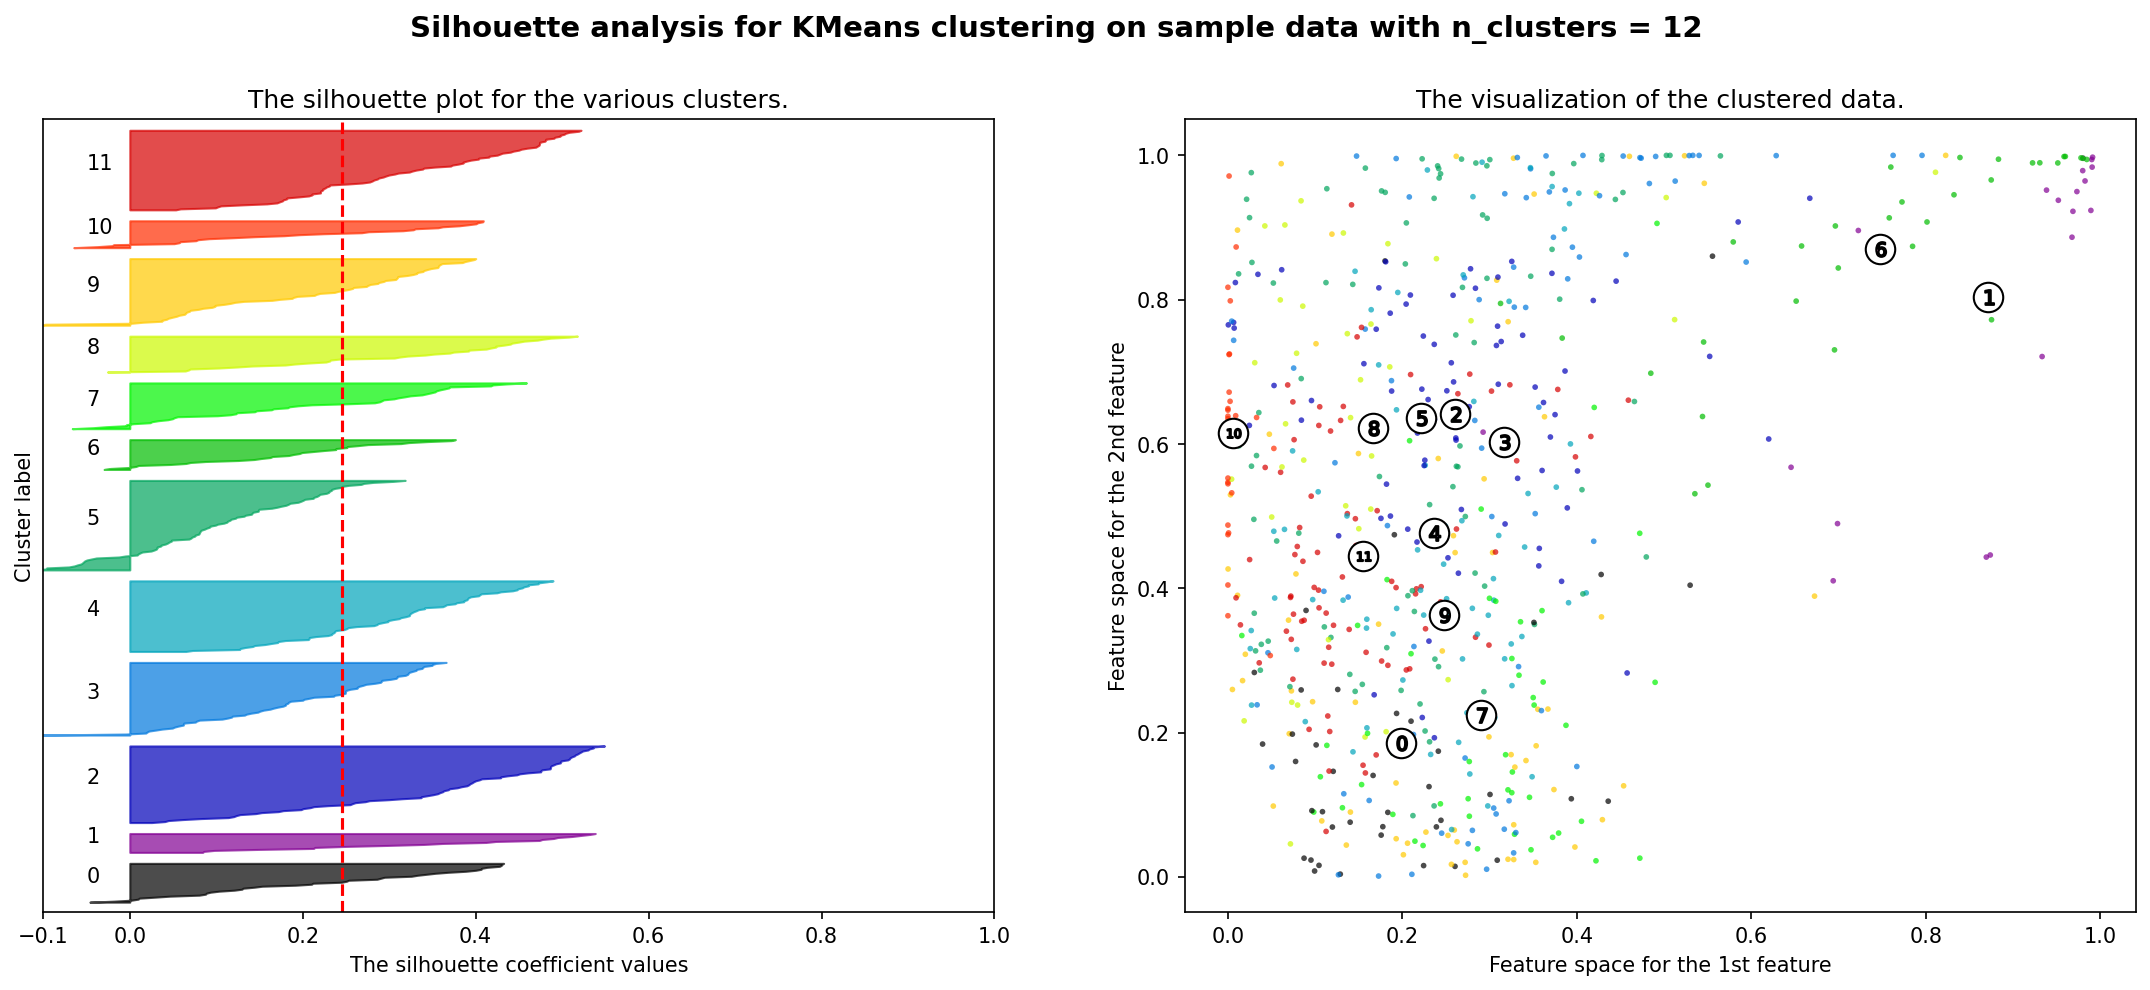

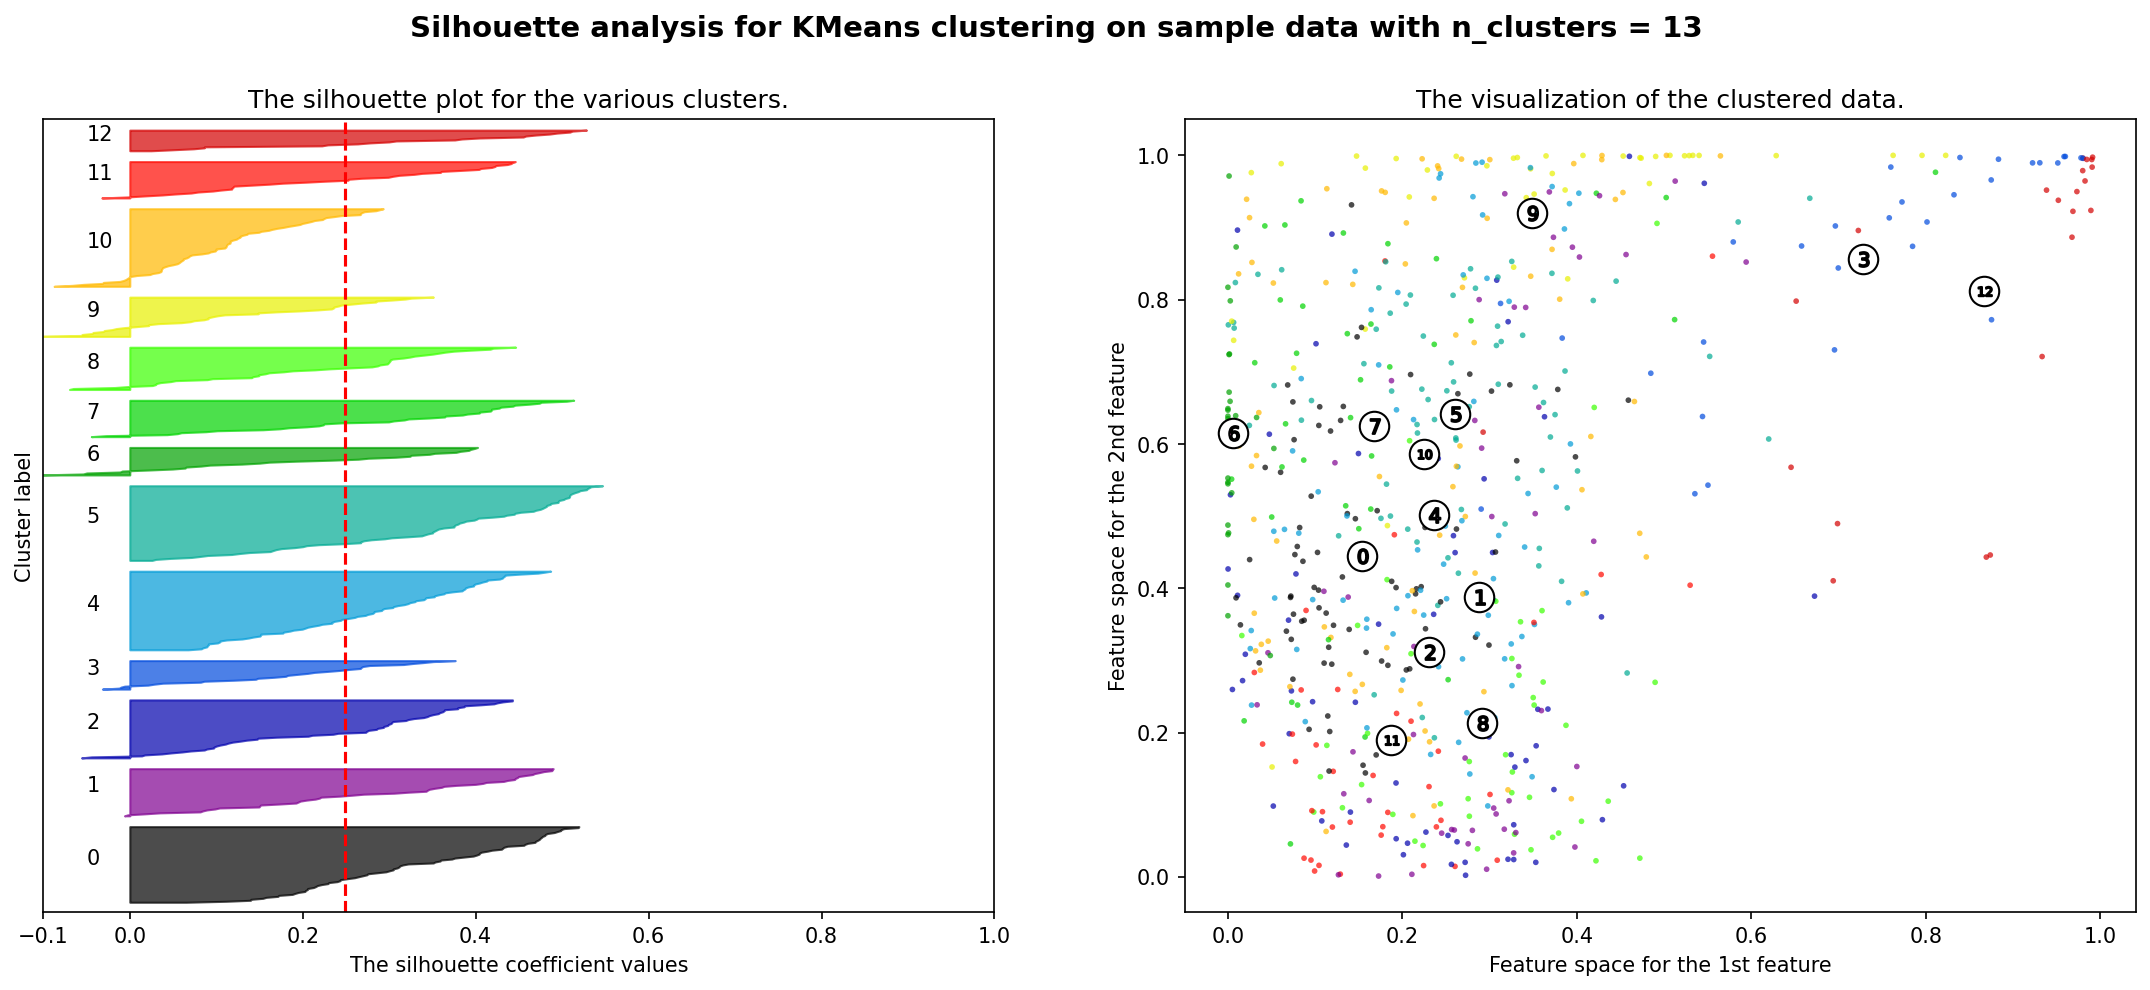

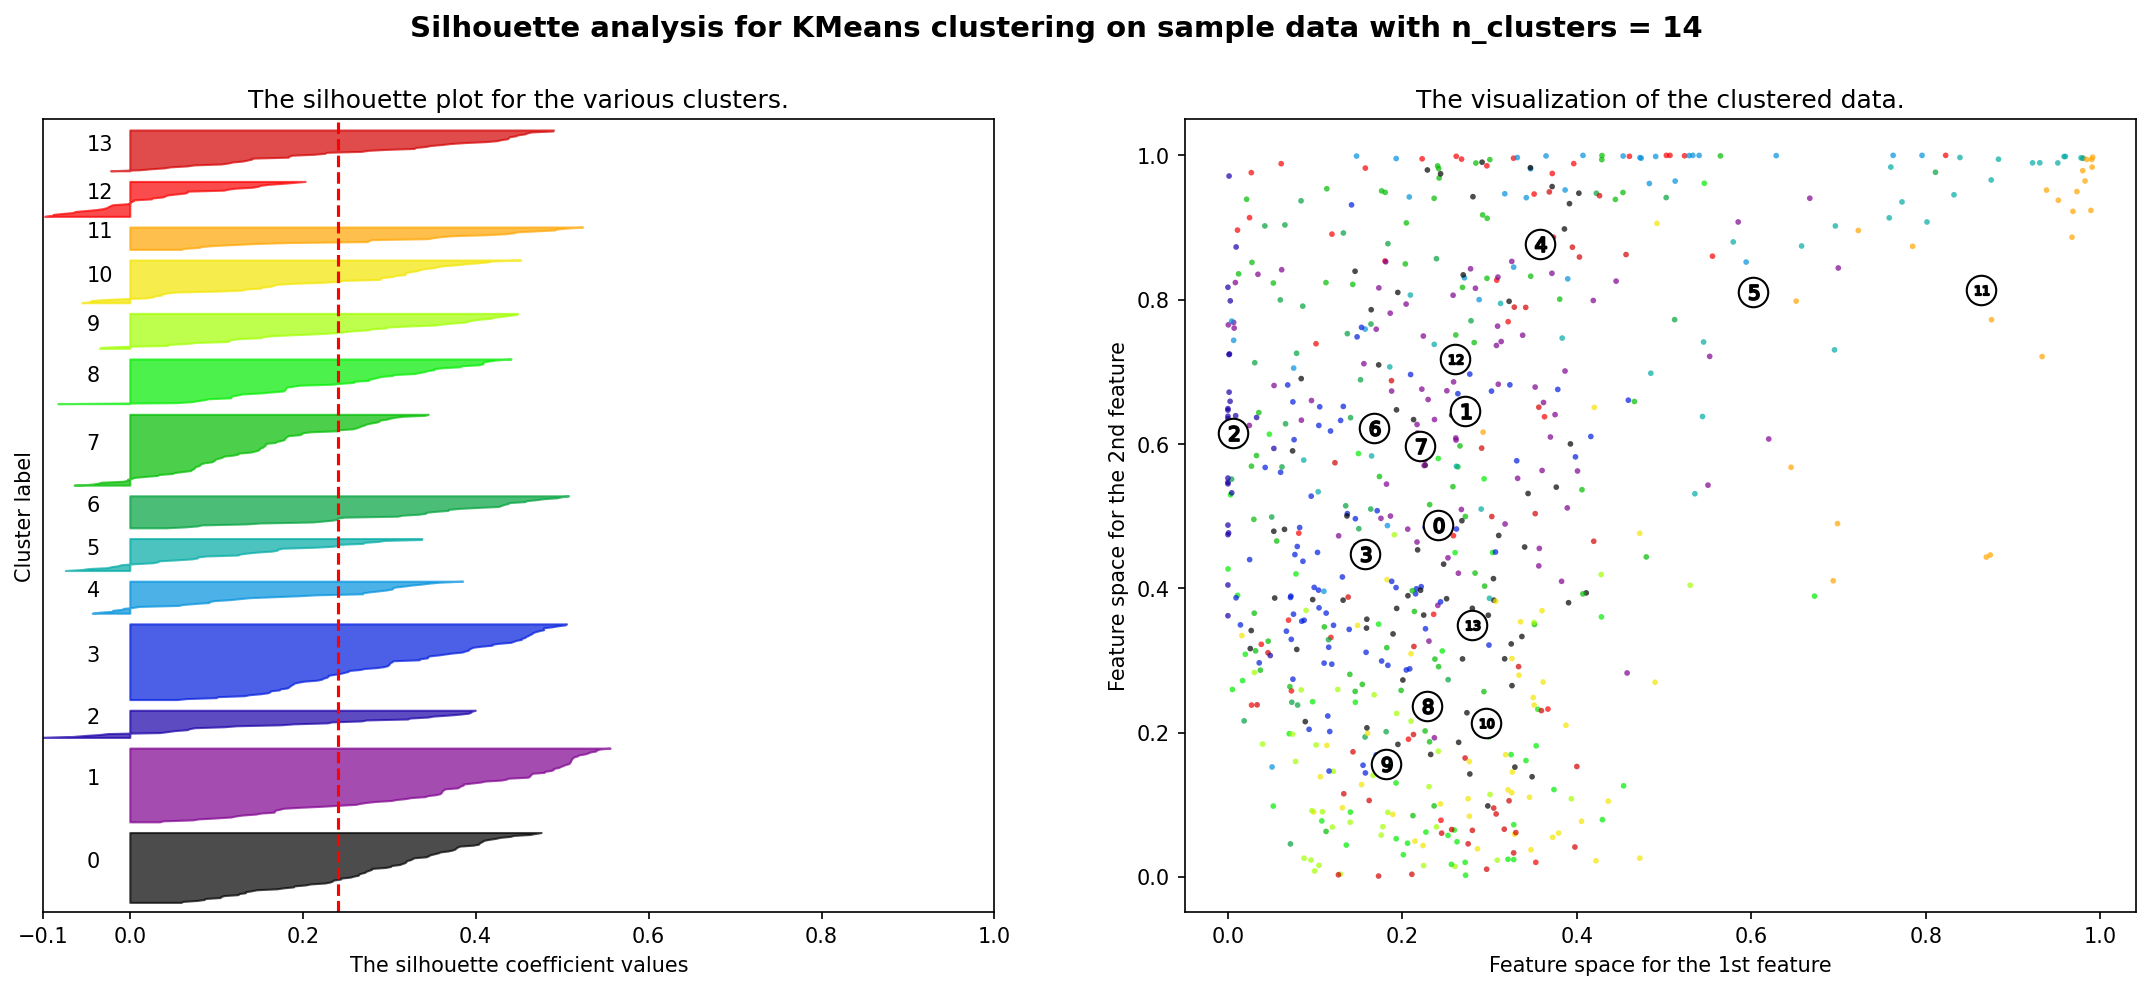

In [59]:
run_multiple_cluster_comparisons(all_embeddings)

# What features are we using

In [105]:
display(cfg["camels_attributes"])

['area',
 'elev_mean',
 'sand_perc',
 'silt_perc',
 'clay_perc',
 'porosity_hypres',
 'conductivity_hypres',
 'soil_depth_pelletier',
 'dwood_perc',
 'ewood_perc',
 'crop_perc',
 'urban_perc',
 'reservoir_cap']

In [108]:
display(cfg["dynamic_inputs"])

['precipitation', 'peti', 'temperature']